# 📝 Handwriting Detection & Recognition Pipeline

## Local Training with RTX 3050 (CUDA)

**Overview:** This notebook implements a complete handwriting detection and OCR pipeline using:
- **Detection:** YOLOv8 (Ultralytics) for locating handwriting regions
- **Recognition:** TrOCR (Microsoft) for handwriting-to-text conversion
- **Hardware:** NVIDIA RTX 3050 with CUDA acceleration

### 📁 Output Locations (Local)
| Item | Path |
|------|------|
| YOLO Checkpoints | `./handwriting_pipeline/yolo_runs/` |
| Trained Model | `./handwriting_pipeline/best.pt` |
| Cropped Images | `./handwriting_pipeline/crops/` |
| Predictions | `./handwriting_pipeline/predictions/` |

### 🚀 Quick Start
1. Run cells **top-to-bottom** (Ctrl+Enter)
2. Ensure CUDA is available (RTX 3050)
3. Training takes ~20-40 min on RTX 3050 (synthetic dataset)
4. Use `predict(image_path)` for inference

### ⚙️ Resume Training
```python
model = YOLO('./handwriting_pipeline/last.pt')
model.train(resume=True)
```

### 📊 Expected Performance
- Detection mAP@0.5: ~0.85+ (synthetic data)
- OCR CER: ~5-15% (TrOCR pretrained on handwriting)

### 🎮 RTX 3050 Optimizations
- Mixed precision (FP16) enabled for faster training
- Optimized batch size for 4GB VRAM
- CUDA memory management enabled

## 1️⃣ Environment Setup
Install all dependencies and configure local storage for persistent training.

In [17]:
# ============================================================
# Cell 1.1: Setup Local Project Directory
# Expected runtime: ~1 second
# ============================================================

import os
from pathlib import Path

# Use local directory (relative to notebook location)
PROJECT_ROOT = './handwriting_pipeline'

# Create project directories
DIRS = ['yolo_runs', 'crops', 'predictions', 'dataset', 'dataset/images/train',
        'dataset/images/val', 'dataset/labels/train', 'dataset/labels/val']
for d in DIRS:
    os.makedirs(f'{PROJECT_ROOT}/{d}', exist_ok=True)

print(f"✅ Project root: {os.path.abspath(PROJECT_ROOT)}")
print(f"✅ All directories created successfully")
print(f"📁 Local storage - data persists between sessions")

✅ Project root: c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline
✅ All directories created successfully
📁 Local storage - data persists between sessions


In [18]:
# ============================================================
# Cell 1.2: Install Required Packages & Verify RTX 3050 CUDA
# Expected runtime: ~2-3 minutes (first run only)
# ============================================================

# Install ultralytics (YOLOv8), transformers, and OCR dependencies
# Uncomment the pip installs if running for the first time
# !pip install ultralytics>=8.0.0
# !pip install transformers>=4.30.0 datasets evaluate jiwer
# !pip install Pillow opencv-python matplotlib seaborn
# !pip install easyocr  # Fallback OCR option

# Verify GPU availability - RTX 3050 CUDA Setup
import torch

print("=" * 50)
print("🎮 RTX 3050 CUDA Configuration")
print("=" * 50)
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✅ CUDA version: {torch.version.cuda}")
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Memory: {gpu_mem:.1f} GB")
    
    # RTX 3050 optimizations
    torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
    torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 for faster matmul
    torch.backends.cudnn.allow_tf32 = True
    print(f"✅ cuDNN benchmark: Enabled")
    print(f"✅ TF32 acceleration: Enabled")
    
    # Memory management for 4GB VRAM
    torch.cuda.empty_cache()
    print(f"✅ CUDA cache cleared")
else:
    print("⚠️ CUDA not available! Training will be slow on CPU.")
    print("   Make sure you have:")
    print("   1. NVIDIA drivers installed")
    print("   2. CUDA toolkit installed")
    print("   3. PyTorch with CUDA support: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118")

🎮 RTX 3050 CUDA Configuration
✅ PyTorch version: 2.7.1+cu118
✅ CUDA available: True
✅ CUDA version: 11.8
✅ GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
✅ GPU Memory: 6.4 GB
✅ cuDNN benchmark: Enabled
✅ TF32 acceleration: Enabled
✅ CUDA cache cleared


In [19]:
# ============================================================
# Cell 1.3: Import Libraries & Global Config
# ============================================================

import os
import cv2
import json
import random
import shutil
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass

# Ultralytics YOLO
from ultralytics import YOLO

# Transformers for TrOCR
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Evaluation metrics
from jiwer import wer, cer

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Global paths - LOCAL STORAGE
PROJECT_ROOT = './handwriting_pipeline'
DATASET_PATH = f'{PROJECT_ROOT}/dataset'
YOLO_RUNS = f'{PROJECT_ROOT}/yolo_runs'
CROPS_PATH = f'{PROJECT_ROOT}/crops'
PREDICTIONS_PATH = f'{PROJECT_ROOT}/predictions'

# Device configuration for RTX 3050
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("✅ All imports successful")
print(f"✅ Device: {DEVICE}")
print(f"✅ Project root: {os.path.abspath(PROJECT_ROOT)}")

✅ All imports successful
✅ Device: cuda
✅ Project root: c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline


## 2️⃣ Dataset Preparation
Since IAM-OnDB requires authentication, we'll create a **synthetic handwriting dataset** for quick development. This generates realistic handwriting-style images with known ground truth.

In [20]:
# ============================================================
# Cell 2.1: Synthetic Handwriting Dataset Generator
# Generates images with handwriting-style text and YOLO labels
# Expected runtime: ~1-2 minutes for 500 samples
# ============================================================

@dataclass
class TextBox:
    """Represents a text region with bounding box and content."""
    x1: int
    y1: int
    x2: int
    y2: int
    text: str

class SyntheticHandwritingGenerator:
    """Generate synthetic handwriting images with YOLO-format labels."""

    def __init__(self, output_dir: str, img_size: Tuple[int, int] = (1024, 768)):
        self.output_dir = Path(output_dir)
        self.img_size = img_size
        self.class_id = 0  # Single class: "handwriting"

        # Sample text corpus
        self.sentences = [
            "The quick brown fox jumps over the lazy dog",
            "Hello world this is a test",
            "Machine learning is amazing",
            "Handwriting recognition works",
            "Python is my favorite language",
            "Deep learning neural networks",
            "Computer vision applications",
            "Natural language processing",
            "Artificial intelligence future",
            "Data science and analytics",
            "The weather is nice today",
            "Please sign the document below",
            "Meeting scheduled for Monday",
            "Important notes to remember",
            "Call back tomorrow morning",
        ]

        self.words = [
            "hello", "world", "test", "sample", "data", "model", "train",
            "predict", "image", "text", "write", "read", "learn", "code",
            "python", "neural", "deep", "vision", "ocr", "detect"
        ]

    def _get_font(self, size: int = 32):
        """Get a handwriting-style font or fallback to default (Windows compatible)."""
        import sys
        
        # Windows font paths
        if sys.platform == 'win32':
            font_paths = [
                "C:/Windows/Fonts/arial.ttf",
                "C:/Windows/Fonts/calibri.ttf",
                "C:/Windows/Fonts/times.ttf",
                "C:/Windows/Fonts/segoeui.ttf",
            ]
        else:
            # Linux/Mac font paths
            font_paths = [
                "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
                "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf",
                "/System/Library/Fonts/Helvetica.ttc",
            ]
        
        for fp in font_paths:
            if os.path.exists(fp):
                try:
                    return ImageFont.truetype(fp, size)
                except:
                    continue
        return ImageFont.load_default()

    def _add_noise(self, img: np.ndarray) -> np.ndarray:
        """Add realistic paper texture and noise."""
        # Gaussian noise
        noise = np.random.normal(0, 5, img.shape).astype(np.uint8)
        img = cv2.add(img, noise)

        # Slight blur for realism
        if random.random() > 0.5:
            img = cv2.GaussianBlur(img, (3, 3), 0)

        return img

    def generate_image(self) -> Tuple[Image.Image, List[TextBox]]:
        """Generate a single synthetic handwriting image."""
        # Create background (slightly off-white paper)
        bg_color = (random.randint(240, 255), random.randint(240, 255), random.randint(235, 250))
        img = Image.new('RGB', self.img_size, bg_color)
        draw = ImageDraw.Draw(img)

        text_boxes = []
        y_cursor = random.randint(30, 60)

        # Generate 3-8 lines of text
        num_lines = random.randint(3, 8)

        for _ in range(num_lines):
            if y_cursor > self.img_size[1] - 100:
                break

            # Random font size for variety
            font_size = random.randint(24, 42)
            font = self._get_font(font_size)

            # Choose text: sentence or random words
            if random.random() > 0.3:
                text = random.choice(self.sentences)
            else:
                num_words = random.randint(2, 5)
                text = " ".join(random.choices(self.words, k=num_words))

            # Random text color (dark variations)
            text_color = (
                random.randint(0, 50),
                random.randint(0, 50),
                random.randint(0, 80)
            )

            # Random x position (slight indent)
            x_pos = random.randint(20, 100)

            # Get text bounding box
            bbox = draw.textbbox((x_pos, y_cursor), text, font=font)

            # Ensure text fits in image
            if bbox[2] > self.img_size[0] - 20:
                # Truncate text to fit
                while bbox[2] > self.img_size[0] - 20 and len(text) > 5:
                    text = text[:-5]
                    bbox = draw.textbbox((x_pos, y_cursor), text, font=font)

            # Draw text
            draw.text((x_pos, y_cursor), text, font=font, fill=text_color)

            # Store bounding box
            text_boxes.append(TextBox(
                x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3], text=text
            ))

            # Move cursor down
            y_cursor += font_size + random.randint(20, 50)

        # Add noise/texture
        img_np = np.array(img)
        img_np = self._add_noise(img_np)
        img = Image.fromarray(img_np)

        return img, text_boxes

    def to_yolo_format(self, boxes: List[TextBox], img_w: int, img_h: int) -> List[str]:
        """Convert bounding boxes to YOLO format: class x_center y_center width height."""
        labels = []
        for box in boxes:
            x_center = ((box.x1 + box.x2) / 2) / img_w
            y_center = ((box.y1 + box.y2) / 2) / img_h
            width = (box.x2 - box.x1) / img_w
            height = (box.y2 - box.y1) / img_h

            # Clamp values to [0, 1]
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            width = max(0, min(1, width))
            height = max(0, min(1, height))

            labels.append(f"{self.class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        return labels

    def generate_dataset(self, n_train: int = 400, n_val: int = 100) -> Dict:
        """Generate complete dataset with train/val splits."""
        ground_truth = {"train": {}, "val": {}}

        for split, n_samples in [("train", n_train), ("val", n_val)]:
            img_dir = self.output_dir / "images" / split
            label_dir = self.output_dir / "labels" / split
            img_dir.mkdir(parents=True, exist_ok=True)
            label_dir.mkdir(parents=True, exist_ok=True)

            print(f"Generating {split} set ({n_samples} images)...")

            for i in range(n_samples):
                img, boxes = self.generate_image()

                # Save image
                img_path = img_dir / f"img_{i:04d}.jpg"
                img.save(img_path, quality=95)

                # Save YOLO labels
                labels = self.to_yolo_format(boxes, self.img_size[0], self.img_size[1])
                label_path = label_dir / f"img_{i:04d}.txt"
                with open(label_path, 'w') as f:
                    f.write('\n'.join(labels))

                # Store ground truth text
                ground_truth[split][f"img_{i:04d}"] = [box.text for box in boxes]

                if (i + 1) % 100 == 0:
                    print(f"  Generated {i + 1}/{n_samples}")

        # Save ground truth JSON
        gt_path = self.output_dir / "ground_truth.json"
        with open(gt_path, 'w') as f:
            json.dump(ground_truth, f, indent=2)

        print(f"✅ Dataset saved to {os.path.abspath(self.output_dir)}")
        print(f"✅ Ground truth saved to {gt_path}")

        return ground_truth

# Generate dataset
generator = SyntheticHandwritingGenerator(DATASET_PATH)
ground_truth = generator.generate_dataset(n_train=400, n_val=100)

Generating train set (400 images)...
  Generated 100/400
  Generated 100/400
  Generated 200/400
  Generated 200/400
  Generated 300/400
  Generated 300/400
  Generated 400/400
Generating val set (100 images)...
  Generated 400/400
Generating val set (100 images)...
  Generated 100/100
✅ Dataset saved to c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\dataset
✅ Ground truth saved to handwriting_pipeline\dataset\ground_truth.json
  Generated 100/100
✅ Dataset saved to c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\dataset
✅ Ground truth saved to handwriting_pipeline\dataset\ground_truth.json


In [21]:
# ============================================================
# Cell 2.2: Create YOLO Dataset Config (data.yaml)
# ============================================================

data_yaml = f"""
# Handwriting Detection Dataset
path: {DATASET_PATH}
train: images/train
val: images/val

# Classes
names:
  0: handwriting

# Number of classes
nc: 1
"""

yaml_path = f'{DATASET_PATH}/data.yaml'
with open(yaml_path, 'w') as f:
    f.write(data_yaml.strip())

print(f"✅ Dataset config saved to {yaml_path}")
print(data_yaml)

✅ Dataset config saved to ./handwriting_pipeline/dataset/data.yaml

# Handwriting Detection Dataset
path: ./handwriting_pipeline/dataset
train: images/train
val: images/val

# Classes
names:
  0: handwriting

# Number of classes
nc: 1



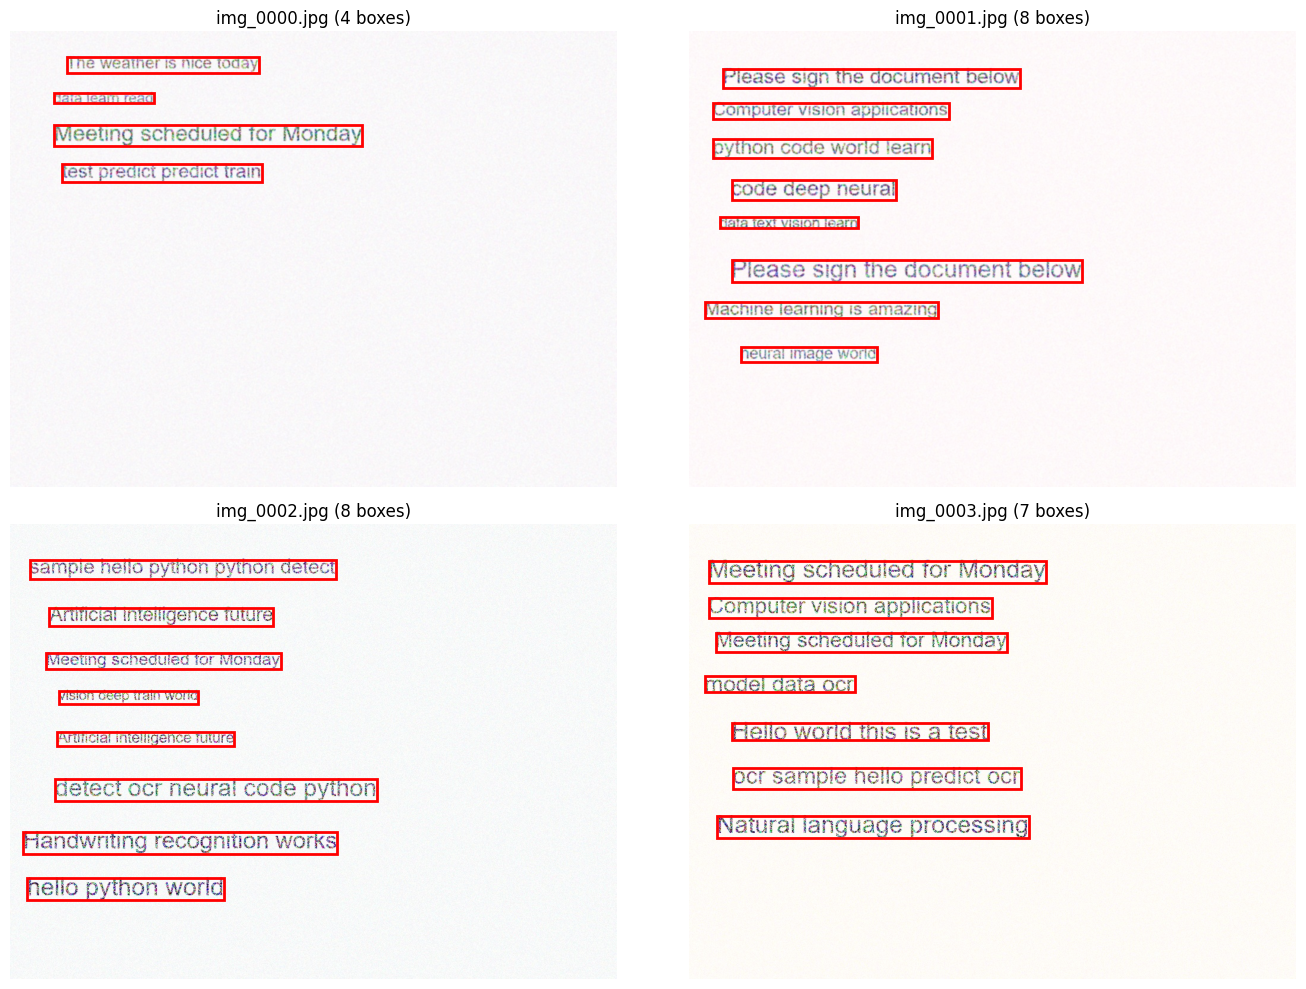

✅ Visualization saved to ./handwriting_pipeline/sample_visualization.png


In [22]:
# ============================================================
# Cell 2.3: Visualize Sample Dataset Images with Bounding Boxes
# ============================================================

def visualize_samples(dataset_path: str, split: str = "train", n_samples: int = 4):
    """Display sample images with YOLO bounding boxes overlaid."""
    img_dir = Path(dataset_path) / "images" / split
    label_dir = Path(dataset_path) / "labels" / split

    images = sorted(list(img_dir.glob("*.jpg")))[:n_samples]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, img_path in enumerate(images):
        # Load image
        img = Image.open(img_path)
        img_w, img_h = img.size

        # Load labels
        label_path = label_dir / f"{img_path.stem}.txt"
        boxes = []
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, xc, yc, w, h = map(float, parts)
                        # Convert YOLO to pixel coords
                        x1 = (xc - w/2) * img_w
                        y1 = (yc - h/2) * img_h
                        box_w = w * img_w
                        box_h = h * img_h
                        boxes.append((x1, y1, box_w, box_h))

        # Plot
        axes[idx].imshow(img)
        for (x1, y1, bw, bh) in boxes:
            rect = patches.Rectangle((x1, y1), bw, bh,
                                      linewidth=2, edgecolor='red', facecolor='none')
            axes[idx].add_patch(rect)
        axes[idx].set_title(f"{img_path.name} ({len(boxes)} boxes)")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(f'{PROJECT_ROOT}/sample_visualization.png', dpi=150)
    plt.show()
    print(f"✅ Visualization saved to {PROJECT_ROOT}/sample_visualization.png")

visualize_samples(DATASET_PATH, "train", n_samples=4)

## 3️⃣ YOLO Detection Training
Train YOLOv8 to detect handwriting regions. Config optimized for RTX 3050 (4GB VRAM).

**Tips for RTX 3050 Memory (4GB VRAM):**
- Use `batch=8` (default) - reduce to 4 if OOM
- Use `imgsz=640` for best speed/accuracy trade-off
- `amp=True` enables FP16 mixed precision (faster, less memory)
- `workers=4` for good CPU data loading balance

In [23]:
# ============================================================
# Cell 3.1: Train YOLOv8 Detector (RTX 3050 Optimized)
# Expected runtime: ~20-40 minutes on RTX 3050
# ============================================================

# Clear CUDA cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load YOLOv8 nano model (fastest, best for RTX 3050 4GB)
model = YOLO('yolov8n.pt')  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt

# Training configuration optimized for RTX 3050 (4GB VRAM)
results = model.train(
    data=f'{DATASET_PATH}/data.yaml',
    epochs=30,                    # Increase for better results
    imgsz=640,                    # 640 optimal for RTX 3050
    batch=8,                      # 8 for 4GB VRAM, reduce to 4 if OOM
    workers=4,                    # Balance CPU workers for Windows
    project=YOLO_RUNS,
    name='handwriting_detect',
    exist_ok=True,
    patience=10,                  # Early stopping patience
    save=True,
    save_period=10,               # Save checkpoint every N epochs
    device=0,                     # GPU 0 (RTX 3050)
    amp=True,                     # Mixed precision (FP16) - ESSENTIAL for RTX 3050
    verbose=True,
    plots=True,                   # Generate training plots
    cache=True,                   # Cache images in RAM for faster training
    cos_lr=True,                  # Cosine learning rate scheduler
    optimizer='AdamW',            # AdamW optimizer
)

print(f"✅ Training complete!")
print(f"✅ Best model saved to: {YOLO_RUNS}/handwriting_detect/weights/best.pt")

Ultralytics 8.3.234  Python-3.12.12 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=./handwriting_pipeline/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=handwriting_detect, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, pa

✅ Best model copied to: c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\best.pt


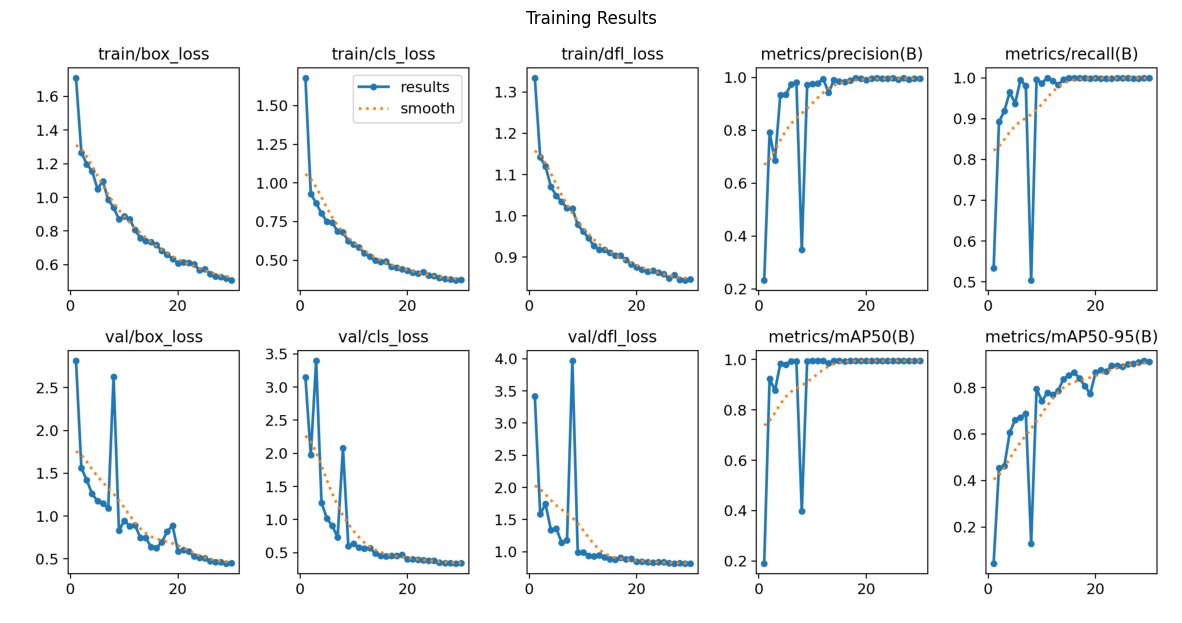


📊 GPU Memory after training:
   Allocated: 0.11 GB
   Cached: 0.39 GB


In [24]:
# ============================================================
# Cell 3.2: Copy Best Model & Show Training Results
# ============================================================

import shutil

# Copy best model to easy-access location
best_model_src = f'{YOLO_RUNS}/handwriting_detect/weights/best.pt'
best_model_dst = f'{PROJECT_ROOT}/best.pt'

if os.path.exists(best_model_src):
    shutil.copy(best_model_src, best_model_dst)
    print(f"✅ Best model copied to: {os.path.abspath(best_model_dst)}")
else:
    print("⚠️ Best model not found - training may still be in progress")

# Display training results
results_img = f'{YOLO_RUNS}/handwriting_detect/results.png'
if os.path.exists(results_img):
    img = Image.open(results_img)
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results')
    plt.show()

# Show GPU memory usage after training
if torch.cuda.is_available():
    print(f"\n📊 GPU Memory after training:")
    print(f"   Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"   Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

In [25]:
# ============================================================
# Cell 3.3: Resume Training (if interrupted)
# Run this cell ONLY if you need to resume training
# ============================================================

# Uncomment to resume training from last checkpoint:
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
# last_checkpoint = f'{YOLO_RUNS}/handwriting_detect/weights/last.pt'
# if os.path.exists(last_checkpoint):
#     model = YOLO(last_checkpoint)
#     results = model.train(resume=True)
#     print("✅ Training resumed successfully")
# else:
#     print("⚠️ No checkpoint found to resume from")

print("ℹ️ Uncomment the code above to resume training from the last checkpoint")
print(f"   Checkpoint path: {os.path.abspath(YOLO_RUNS)}/handwriting_detect/weights/last.pt")

ℹ️ Uncomment the code above to resume training from the last checkpoint
   Checkpoint path: c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\yolo_runs/handwriting_detect/weights/last.pt


## 4️⃣ Detection Inference & Cropping
Run the trained YOLO model to detect handwriting regions and crop them for OCR.

In [26]:
# ============================================================
# Cell 4.1: Load Trained Model & Run Detection
# ============================================================

class HandwritingDetector:
    """YOLO-based handwriting region detector."""

    def __init__(self, model_path: str, conf_threshold: float = 0.25):
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold

    def detect(self, image_path: str) -> List[Dict]:
        """Detect handwriting regions in an image.

        Returns:
            List of dicts with keys: box (x1,y1,x2,y2), confidence
        """
        results = self.model(image_path, conf=self.conf_threshold, verbose=False)

        detections = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = float(box.conf[0].cpu().numpy())
                detections.append({
                    'box': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': round(conf, 4)
                })

        # Sort by y-coordinate (top to bottom), then x (left to right)
        detections.sort(key=lambda d: (d['box'][1], d['box'][0]))

        return detections

    def crop_regions(self, image_path: str, detections: List[Dict],
                     output_dir: str, padding: int = 5) -> List[str]:
        """Crop detected regions and save to disk.

        Returns:
            List of paths to cropped images
        """
        os.makedirs(output_dir, exist_ok=True)
        img = Image.open(image_path)
        img_w, img_h = img.size

        crop_paths = []
        base_name = Path(image_path).stem

        for idx, det in enumerate(detections):
            x1, y1, x2, y2 = det['box']

            # Add padding (clamped to image bounds)
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(img_w, x2 + padding)
            y2 = min(img_h, y2 + padding)

            # Crop and save
            crop = img.crop((x1, y1, x2, y2))
            crop_path = f"{output_dir}/{base_name}_crop_{idx:02d}.jpg"
            crop.save(crop_path, quality=95)
            crop_paths.append(crop_path)

        return crop_paths

# Load the trained model
model_path = f'{PROJECT_ROOT}/best.pt'
if not os.path.exists(model_path):
    model_path = f'{YOLO_RUNS}/handwriting_detect/weights/best.pt'

detector = HandwritingDetector(model_path)
print(f"✅ Detector loaded from: {model_path}")

✅ Detector loaded from: ./handwriting_pipeline/best.pt



img_0000.jpg: 3 detections


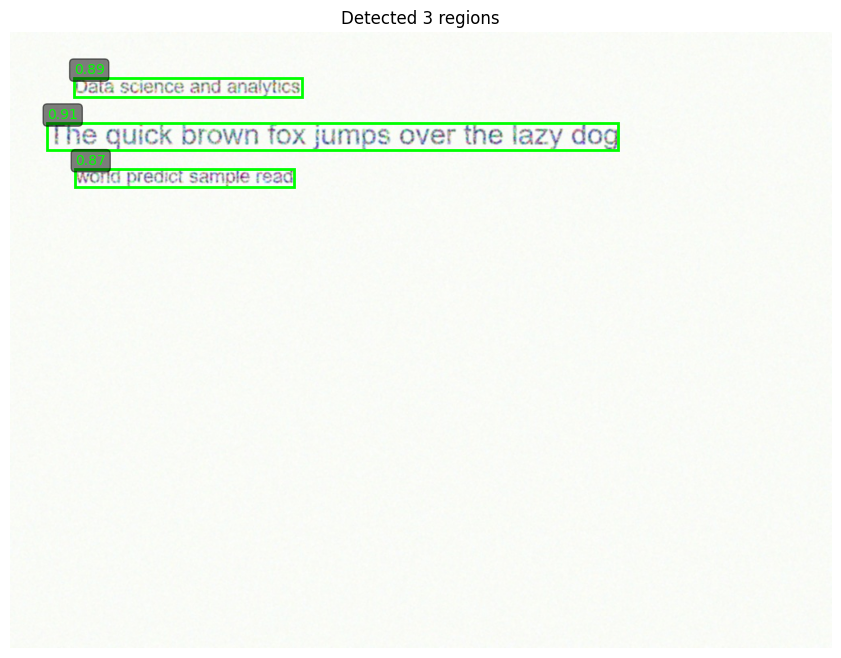


img_0001.jpg: 6 detections


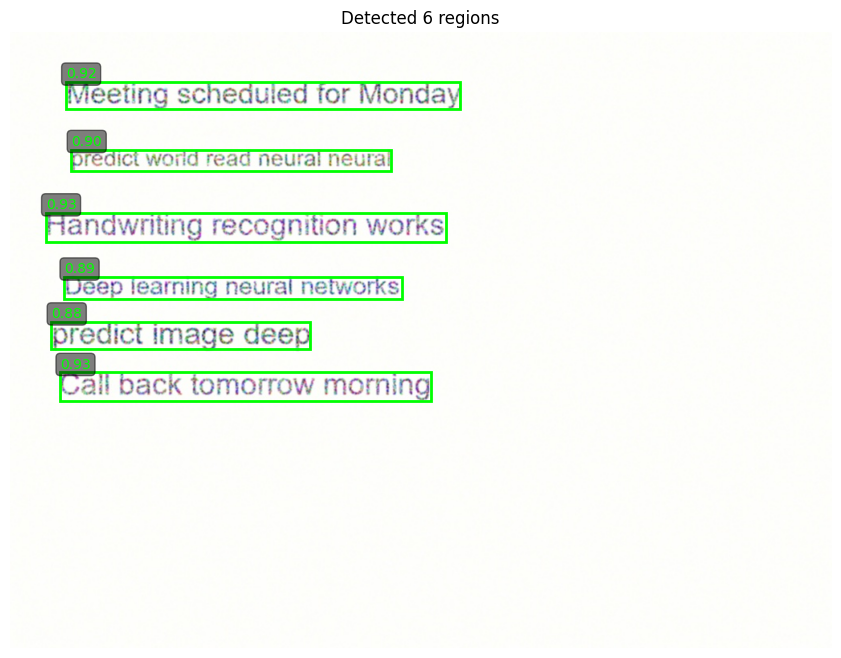


img_0002.jpg: 7 detections


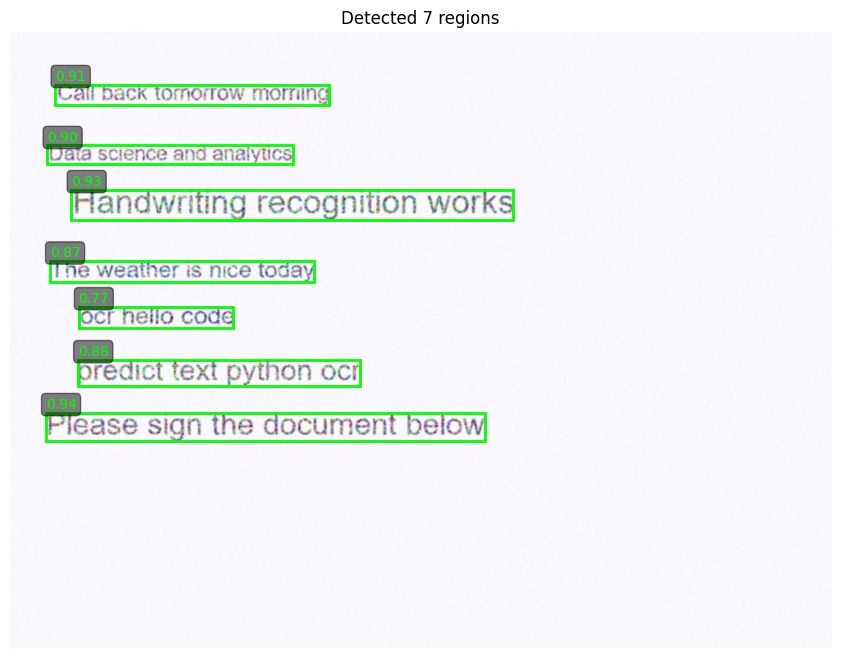

In [27]:
# ============================================================
# Cell 4.2: Test Detection on Sample Images
# ============================================================

def visualize_detections(image_path: str, detections: List[Dict], save_path: str = None):
    """Draw detection boxes on image."""
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)

    for det in detections:
        x1, y1, x2, y2 = det['box']
        conf = det['confidence']
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                  linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{conf:.2f}", color='lime', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

    ax.set_title(f"Detected {len(detections)} regions")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Test on validation images
val_images = sorted(list(Path(f'{DATASET_PATH}/images/val').glob("*.jpg")))[:3]

for img_path in val_images:
    detections = detector.detect(str(img_path))
    print(f"\n{img_path.name}: {len(detections)} detections")
    visualize_detections(str(img_path), detections)

## 5️⃣ OCR Integration with TrOCR
Use Microsoft's TrOCR model for handwriting recognition on cropped text regions.

In [28]:
# ============================================================
# Cell 5.1: Load TrOCR Model for Handwriting Recognition
# Expected runtime: ~1-2 minutes for model download
# Optimized for RTX 3050 CUDA
# ============================================================

class HandwritingOCR:
    """TrOCR-based handwriting recognition with EasyOCR fallback."""

    def __init__(self, use_trocr: bool = True, device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_trocr = use_trocr

        if use_trocr:
            # TrOCR - specifically trained on handwriting
            print(f"Loading TrOCR handwriting model on {self.device}...")
            self.processor = TrOCRProcessor.from_pretrained(
                'microsoft/trocr-base-handwritten'
            )
            self.model = VisionEncoderDecoderModel.from_pretrained(
                'microsoft/trocr-base-handwritten'
            ).to(self.device)
            self.model.eval()
            
            # Enable half precision on CUDA for faster inference
            if self.device == 'cuda':
                self.model = self.model.half()  # FP16 for RTX 3050
                print(f"✅ TrOCR loaded on {self.device} with FP16 precision")
            else:
                print(f"✅ TrOCR loaded on {self.device}")
        else:
            # EasyOCR fallback
            import easyocr
            self.reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
            print("✅ EasyOCR loaded")

    def recognize(self, image_path: str) -> str:
        """Recognize text in a cropped handwriting image."""
        img = Image.open(image_path).convert('RGB')

        if self.use_trocr:
            # TrOCR inference
            pixel_values = self.processor(
                images=img, return_tensors='pt'
            ).pixel_values.to(self.device)
            
            # Convert to half precision if using CUDA
            if self.device == 'cuda':
                pixel_values = pixel_values.half()

            with torch.no_grad():
                generated_ids = self.model.generate(pixel_values, max_length=128)

            text = self.processor.batch_decode(
                generated_ids, skip_special_tokens=True
            )[0]
        else:
            # EasyOCR inference
            result = self.reader.readtext(str(image_path), detail=0)
            text = ' '.join(result)

        return text.strip()

    def recognize_batch(self, image_paths: List[str], batch_size: int = 8) -> List[str]:
        """Batch recognition for efficiency."""
        results = []

        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]

            if self.use_trocr:
                images = [Image.open(p).convert('RGB') for p in batch_paths]
                pixel_values = self.processor(
                    images=images, return_tensors='pt'
                ).pixel_values.to(self.device)
                
                # Convert to half precision if using CUDA
                if self.device == 'cuda':
                    pixel_values = pixel_values.half()

                with torch.no_grad():
                    generated_ids = self.model.generate(pixel_values, max_length=128)

                texts = self.processor.batch_decode(
                    generated_ids, skip_special_tokens=True
                )
                results.extend([t.strip() for t in texts])
            else:
                for path in batch_paths:
                    results.append(self.recognize(path))

        return results

# Clear cache before loading OCR model
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Initialize OCR with CUDA
ocr = HandwritingOCR(use_trocr=True, device=DEVICE)
print("✅ OCR engine ready")

Loading TrOCR handwriting model on cuda...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ TrOCR loaded on cuda with FP16 precision
✅ OCR engine ready


Testing OCR on 3 cropped regions:

Crop 1: Data science and analytics
Crop 1: Data science and analytics


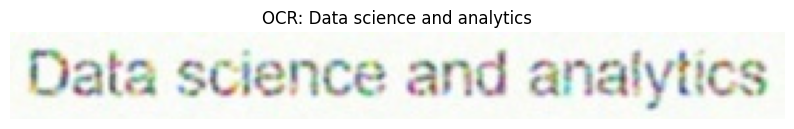

Crop 2: The quick brown fox jumps over the lazy dog


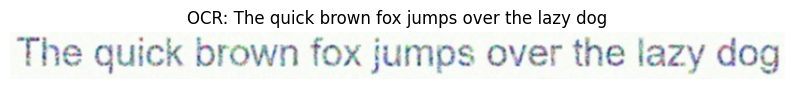

Crop 3: world predict sample read


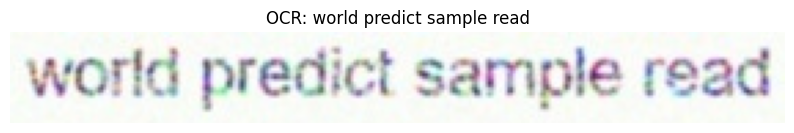

In [29]:
# ============================================================
# Cell 5.2: Test OCR on Sample Crops
# ============================================================

# Create sample crops from validation images
sample_img = str(list(Path(f'{DATASET_PATH}/images/val').glob("*.jpg"))[0])
detections = detector.detect(sample_img)
crop_paths = detector.crop_regions(sample_img, detections, f'{CROPS_PATH}/test')

# Run OCR on crops
print(f"Testing OCR on {len(crop_paths)} cropped regions:\n")

for i, crop_path in enumerate(crop_paths[:5]):  # Limit to 5 for demo
    text = ocr.recognize(crop_path)
    print(f"Crop {i+1}: {text}")

    # Display crop
    crop_img = Image.open(crop_path)
    plt.figure(figsize=(10, 2))
    plt.imshow(crop_img)
    plt.title(f"OCR: {text}")
    plt.axis('off')
    plt.show()

## 6️⃣ Full Pipeline: Detection + OCR + Postprocessing
Combine detection and OCR into a single pipeline with text ordering.

In [30]:
# ============================================================
# Cell 6.1: Complete Handwriting Pipeline Class
# ============================================================

import tempfile

class HandwritingPipeline:
    """End-to-end handwriting detection and recognition pipeline."""

    def __init__(self, detector: HandwritingDetector, ocr: HandwritingOCR):
        self.detector = detector
        self.ocr = ocr
        # Use system temp directory (works on Windows/Linux/Mac)
        self.temp_dir = tempfile.gettempdir()

    def _order_boxes(self, detections: List[Dict], line_threshold: int = 30) -> List[Dict]:
        """Order boxes: top-to-bottom, left-to-right within same line.

        Groups boxes into lines based on y-coordinate overlap,
        then sorts left-to-right within each line.
        """
        if not detections:
            return []

        # Sort primarily by y (top edge)
        sorted_dets = sorted(detections, key=lambda d: d['box'][1])

        # Group into lines
        lines = []
        current_line = [sorted_dets[0]]
        current_y = sorted_dets[0]['box'][1]

        for det in sorted_dets[1:]:
            det_y = det['box'][1]
            # Same line if y overlap within threshold
            if abs(det_y - current_y) < line_threshold:
                current_line.append(det)
            else:
                lines.append(current_line)
                current_line = [det]
                current_y = det_y
        lines.append(current_line)

        # Sort each line left-to-right
        ordered = []
        for line in lines:
            line_sorted = sorted(line, key=lambda d: d['box'][0])
            ordered.extend(line_sorted)

        return ordered

    def predict(self, image_path: str, save_crops: bool = False) -> Dict:
        """Run full pipeline on an image.

        Args:
            image_path: Path to input image
            save_crops: If True, save cropped regions to disk

        Returns:
            Dict with 'detections' list and 'aggregated_text' string
        """
        # Step 1: Detection
        detections = self.detector.detect(image_path)

        # Step 2: Order boxes
        detections = self._order_boxes(detections)

        # Step 3: Crop and OCR
        img = Image.open(image_path)
        img_w, img_h = img.size

        ocr_texts = []
        for idx, det in enumerate(detections):
            x1, y1, x2, y2 = det['box']

            # Crop with padding
            pad = 5
            x1_p = max(0, x1 - pad)
            y1_p = max(0, y1 - pad)
            x2_p = min(img_w, x2 + pad)
            y2_p = min(img_h, y2 + pad)

            crop = img.crop((x1_p, y1_p, x2_p, y2_p))

            # Save temp crop for OCR (Windows-compatible temp directory)
            crop_path = os.path.join(self.temp_dir, f'crop_{idx}.jpg')
            crop.save(crop_path)

            # Run OCR
            text = self.ocr.recognize(crop_path)
            det['ocr_text'] = text
            ocr_texts.append(text)

            # Optional: save crops
            if save_crops:
                base_name = Path(image_path).stem
                save_dir = f'{CROPS_PATH}/{base_name}'
                os.makedirs(save_dir, exist_ok=True)
                crop.save(f'{save_dir}/crop_{idx:02d}.jpg')

        # Step 4: Aggregate text
        aggregated_text = ' '.join(ocr_texts)

        return {
            'detections': detections,
            'aggregated_text': aggregated_text
        }

    def visualize(self, image_path: str, result: Dict, save_path: str = None):
        """Visualize detections with OCR text overlay."""
        img = Image.open(image_path)
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        ax.imshow(img)

        colors = plt.cm.Set2(np.linspace(0, 1, len(result['detections'])))

        for idx, det in enumerate(result['detections']):
            x1, y1, x2, y2 = det['box']
            conf = det['confidence']
            text = det.get('ocr_text', '')[:30]  # Truncate for display

            # Draw box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                      linewidth=2, edgecolor=colors[idx],
                                      facecolor='none')
            ax.add_patch(rect)

            # Add label
            label = f"{conf:.2f}: {text}"
            ax.text(x1, y1-5, label, color='white', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor=colors[idx], alpha=0.8))

        ax.set_title(f"Detected {len(result['detections'])} regions\n"
                     f"Full text: {result['aggregated_text'][:100]}...")
        ax.axis('off')

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

# Create pipeline
pipeline = HandwritingPipeline(detector, ocr)
print("✅ Pipeline ready")

✅ Pipeline ready


## 7️⃣ Evaluation Metrics
Evaluate detection (mAP) and OCR (CER/WER) performance.

In [31]:
# ============================================================
# Cell 7.1: Detection Evaluation (mAP)
# ============================================================

def evaluate_detection(model_path: str, data_yaml: str) -> Dict:
    """Evaluate YOLO detection model on validation set."""
    model = YOLO(model_path)

    # Run validation
    results = model.val(
        data=data_yaml,
        split='val',
        verbose=True,
        plots=True,
        save_json=True
    )

    metrics = {
        'mAP50': float(results.box.map50),
        'mAP50-95': float(results.box.map),
        'precision': float(results.box.mp),
        'recall': float(results.box.mr),
    }

    print("\n📊 Detection Metrics:")
    print(f"  mAP@0.5:     {metrics['mAP50']:.4f}")
    print(f"  mAP@0.5:0.95: {metrics['mAP50-95']:.4f}")
    print(f"  Precision:   {metrics['precision']:.4f}")
    print(f"  Recall:      {metrics['recall']:.4f}")

    return metrics

# Evaluate detection
model_path = f'{PROJECT_ROOT}/best.pt'
if not os.path.exists(model_path):
    model_path = f'{YOLO_RUNS}/handwriting_detect/weights/best.pt'

detection_metrics = evaluate_detection(model_path, f'{DATASET_PATH}/data.yaml')

Ultralytics 8.3.234  Python-3.12.12 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 180.960.6 MB/s, size: 196.4 KB)
val: Scanning C:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\dataset\labels\val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100  0.0sval: Fast image access  (ping: 0.10.1 ms, read: 180.960.6 MB/s, size: 196.4 KB)
val: Scanning C:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\dataset\labels\val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 66.0Kit/s 0.0s
val: Scanning C:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\dataset\labels\val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 66.0Kit/s 0.0s
                 Class     Images  Instances 

In [32]:
# ============================================================
# Cell 7.2: OCR Evaluation (CER/WER)
# ============================================================

def compute_cer_wer(predictions: List[str], references: List[str]) -> Dict:
    """Compute Character Error Rate and Word Error Rate."""
    # Filter empty strings
    valid_pairs = [(p, r) for p, r in zip(predictions, references) if r.strip()]

    if not valid_pairs:
        return {'cer': 0.0, 'wer': 0.0}

    preds, refs = zip(*valid_pairs)

    # Compute metrics
    char_error_rate = cer(list(refs), list(preds))
    word_error_rate = wer(list(refs), list(preds))

    return {
        'cer': char_error_rate,
        'wer': word_error_rate
    }

def evaluate_ocr(pipeline: HandwritingPipeline, dataset_path: str,
                 ground_truth: Dict, split: str = 'val',
                 max_samples: int = 50) -> Dict:
    """Evaluate OCR on dataset with ground truth."""

    img_dir = Path(dataset_path) / "images" / split
    images = sorted(list(img_dir.glob("*.jpg")))[:max_samples]

    all_predictions = []
    all_references = []

    print(f"Evaluating OCR on {len(images)} images...")

    for img_path in images:
        img_name = img_path.stem

        # Get ground truth
        gt_texts = ground_truth.get(split, {}).get(img_name, [])

        # Run pipeline
        result = pipeline.predict(str(img_path))
        pred_texts = [d.get('ocr_text', '') for d in result['detections']]

        # Match predictions to ground truth (simple: concatenate both)
        pred_full = ' '.join(pred_texts)
        gt_full = ' '.join(gt_texts)

        all_predictions.append(pred_full)
        all_references.append(gt_full)

    # Compute metrics
    metrics = compute_cer_wer(all_predictions, all_references)

    print("\n📊 OCR Metrics:")
    print(f"  Character Error Rate (CER): {metrics['cer']:.4f} ({metrics['cer']*100:.2f}%)")
    print(f"  Word Error Rate (WER):      {metrics['wer']:.4f} ({metrics['wer']*100:.2f}%)")

    # Show sample comparisons
    print("\n📝 Sample Comparisons:")
    for i in range(min(3, len(all_predictions))):
        print(f"\n  Sample {i+1}:")
        print(f"    GT:   {all_references[i][:80]}...")
        print(f"    Pred: {all_predictions[i][:80]}...")

    return metrics

# Load ground truth
gt_path = f'{DATASET_PATH}/ground_truth.json'
with open(gt_path, 'r') as f:
    ground_truth = json.load(f)

# Evaluate OCR
ocr_metrics = evaluate_ocr(pipeline, DATASET_PATH, ground_truth, 'val', max_samples=30)

Evaluating OCR on 30 images...

📊 OCR Metrics:
  Character Error Rate (CER): 0.0174 (1.74%)
  Word Error Rate (WER):      0.0394 (3.94%)

📝 Sample Comparisons:

  Sample 1:
    GT:   Data science and analytics The quick brown fox jumps over the lazy dog world pre...
    Pred: Data science and analytics The quick brown fox jumps over the lazy dog world pre...

  Sample 2:
    GT:   Meeting scheduled for Monday predict world read neural neural Handwriting recogn...
    Pred: Meeting scheduled for Monday predict world read neural neural Handwriting recogn...

  Sample 3:
    GT:   Call back tomorrow morning Data science and analytics Handwriting recognition wo...
    Pred: Call back tomorrow morning Data science and analytics Handwriting recognition wo...

📊 OCR Metrics:
  Character Error Rate (CER): 0.0174 (1.74%)
  Word Error Rate (WER):      0.0394 (3.94%)

📝 Sample Comparisons:

  Sample 1:
    GT:   Data science and analytics The quick brown fox jumps over the lazy dog world pre...
 

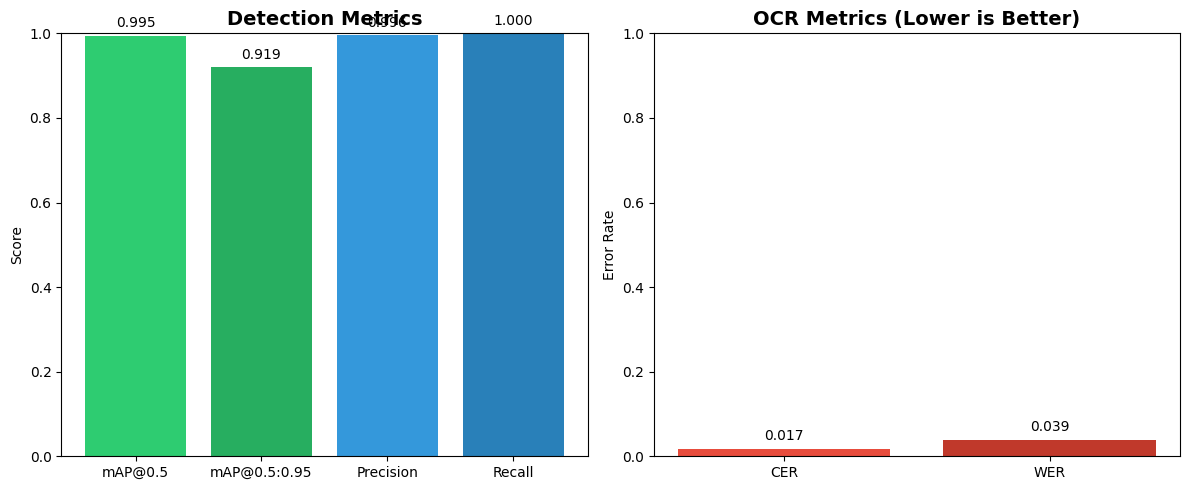

✅ Metrics saved to ./handwriting_pipeline/evaluation_metrics.json


In [33]:
# ============================================================
# Cell 7.3: Summary Metrics & Visualization
# ============================================================

def plot_metrics_summary(detection_metrics: Dict, ocr_metrics: Dict, save_path: str = None):
    """Plot summary of all evaluation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Detection metrics
    det_names = ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall']
    det_values = [detection_metrics.get('mAP50', 0),
                  detection_metrics.get('mAP50-95', 0),
                  detection_metrics.get('precision', 0),
                  detection_metrics.get('recall', 0)]

    bars1 = axes[0].bar(det_names, det_values, color=['#2ecc71', '#27ae60', '#3498db', '#2980b9'])
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Detection Metrics', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Score')

    for bar, val in zip(bars1, det_values):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{val:.3f}', ha='center', fontsize=10)

    # OCR metrics
    ocr_names = ['CER', 'WER']
    ocr_values = [ocr_metrics.get('cer', 0), ocr_metrics.get('wer', 0)]

    bars2 = axes[1].bar(ocr_names, ocr_values, color=['#e74c3c', '#c0392b'])
    axes[1].set_ylim(0, 1)
    axes[1].set_title('OCR Metrics (Lower is Better)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Error Rate')

    for bar, val in zip(bars2, ocr_values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{val:.3f}', ha='center', fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Plot summary
plot_metrics_summary(detection_metrics, ocr_metrics,
                     f'{PROJECT_ROOT}/metrics_summary.png')

# Save metrics to JSON
all_metrics = {
    'detection': detection_metrics,
    'ocr': ocr_metrics
}
with open(f'{PROJECT_ROOT}/evaluation_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(f"✅ Metrics saved to {PROJECT_ROOT}/evaluation_metrics.json")

## 8️⃣ Inference API: `predict()` Function
Production-ready `predict()` function that returns structured JSON output.

In [34]:
# ============================================================
# Cell 8.1: Production-Ready predict() Function
# ============================================================

def predict(image_path: str,
            detector_model_path: str = None,
            conf_threshold: float = 0.25,
            save_visualization: bool = False) -> Dict:
    """
    Run complete handwriting detection and OCR pipeline on an image.

    Args:
        image_path: Path to input image (jpg, png)
        detector_model_path: Path to YOLO model (uses default if None)
        conf_threshold: Detection confidence threshold (0-1)
        save_visualization: If True, save annotated image

    Returns:
        Dict with structure:
        {
            "image_path": str,
            "detections": [
                {"box": [x1,y1,x2,y2], "confidence": float, "ocr_text": str},
                ...
            ],
            "aggregated_text": str,
            "num_detections": int
        }
    """
    # Initialize models if needed (use global if available)
    global pipeline

    if 'pipeline' not in globals():
        model_path = detector_model_path or f'{PROJECT_ROOT}/best.pt'
        _detector = HandwritingDetector(model_path, conf_threshold)
        _ocr = HandwritingOCR(use_trocr=True, device=DEVICE)
        _pipeline = HandwritingPipeline(_detector, _ocr)
    else:
        _pipeline = pipeline

    # Run prediction
    result = _pipeline.predict(image_path, save_crops=False)

    # Format output
    output = {
        "image_path": str(image_path),
        "detections": result['detections'],
        "aggregated_text": result['aggregated_text'],
        "num_detections": len(result['detections'])
    }

    # Optional visualization
    if save_visualization:
        save_path = f"{PREDICTIONS_PATH}/{Path(image_path).stem}_pred.jpg"
        os.makedirs(PREDICTIONS_PATH, exist_ok=True)
        _pipeline.visualize(image_path, result, save_path)
        output["visualization_path"] = os.path.abspath(save_path)

    return output

print("✅ predict() function defined")
print("""
Usage:
    result = predict("path/to/image.jpg")
    print(json.dumps(result, indent=2))
""")

✅ predict() function defined

Usage:
    result = predict("path/to/image.jpg")
    print(json.dumps(result, indent=2))



HANDWRITING DETECTION & OCR DEMO

🖼️ Processing: img_0000.jpg
----------------------------------------


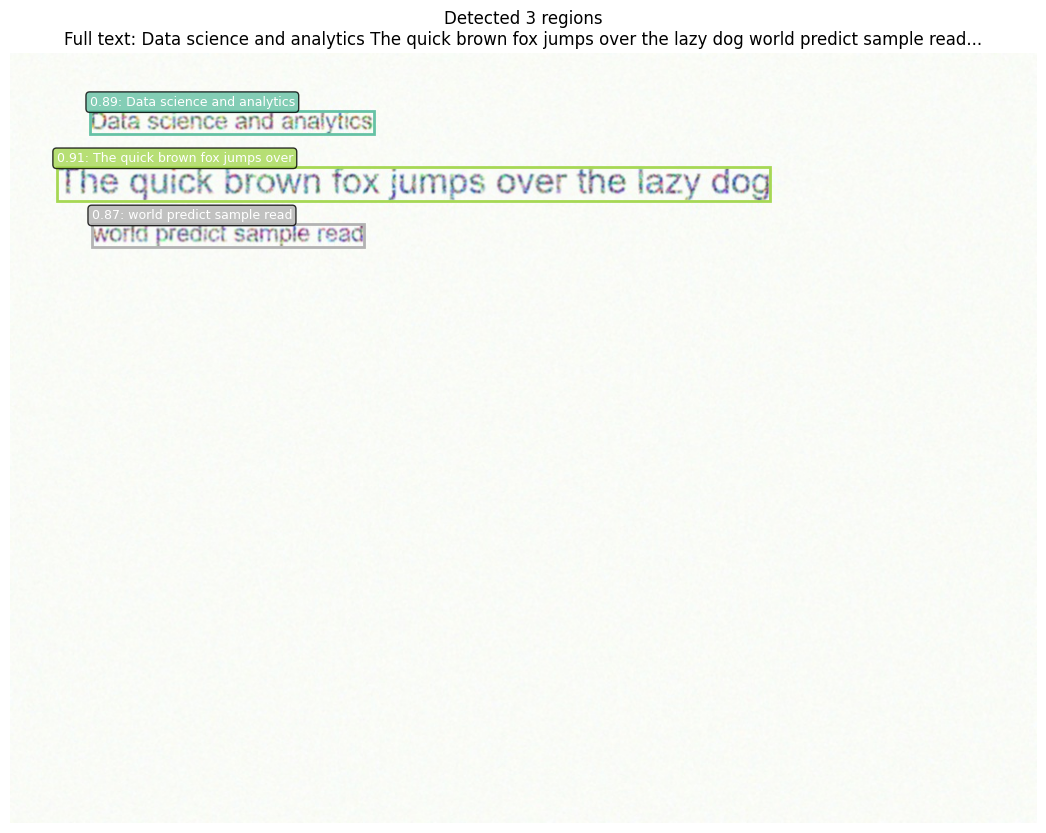

{
  "image_path": "handwriting_pipeline\\dataset\\images\\val\\img_0000.jpg",
  "detections": [
    {
      "box": [
        79,
        57,
        363,
        80
      ],
      "confidence": 0.8889,
      "ocr_text": "Data science and analytics"
    },
    {
      "box": [
        46,
        113,
        758,
        147
      ],
      "confidence": 0.9084,
      "ocr_text": "The quick brown fox jumps over the lazy dog"
    },
    {
      "box": [
        81,
        170,
        353,
        193
      ],
      "confidence": 0.8693,
      "ocr_text": "world predict sample read"
    }
  ],
  "aggregated_text": "Data science and analytics The quick brown fox jumps over the lazy dog world predict sample read",
  "num_detections": 3,
  "visualization_path": "c:\\Users\\LENOVO\\Desktop\\handwriting\\handwriting_pipeline\\predictions\\img_0000_pred.jpg"
}


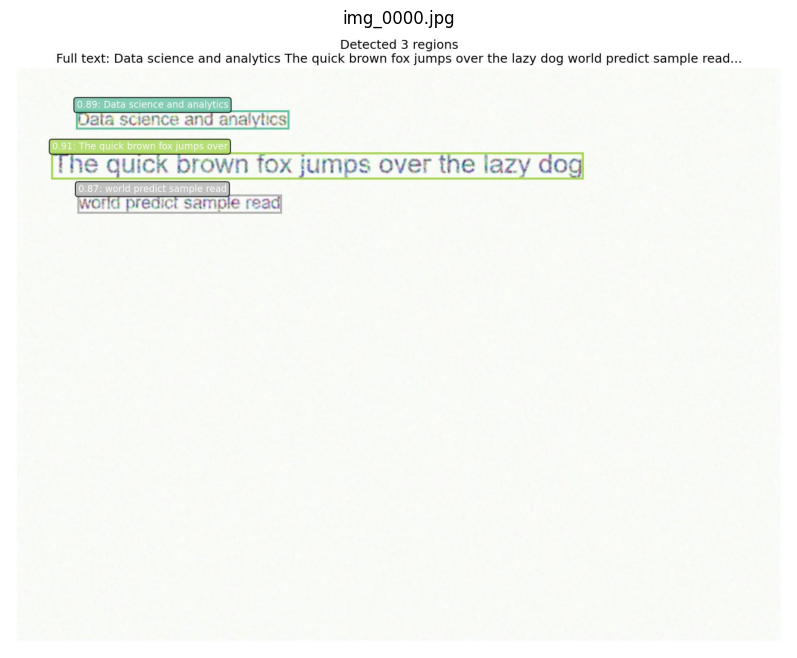


🖼️ Processing: img_0001.jpg
----------------------------------------


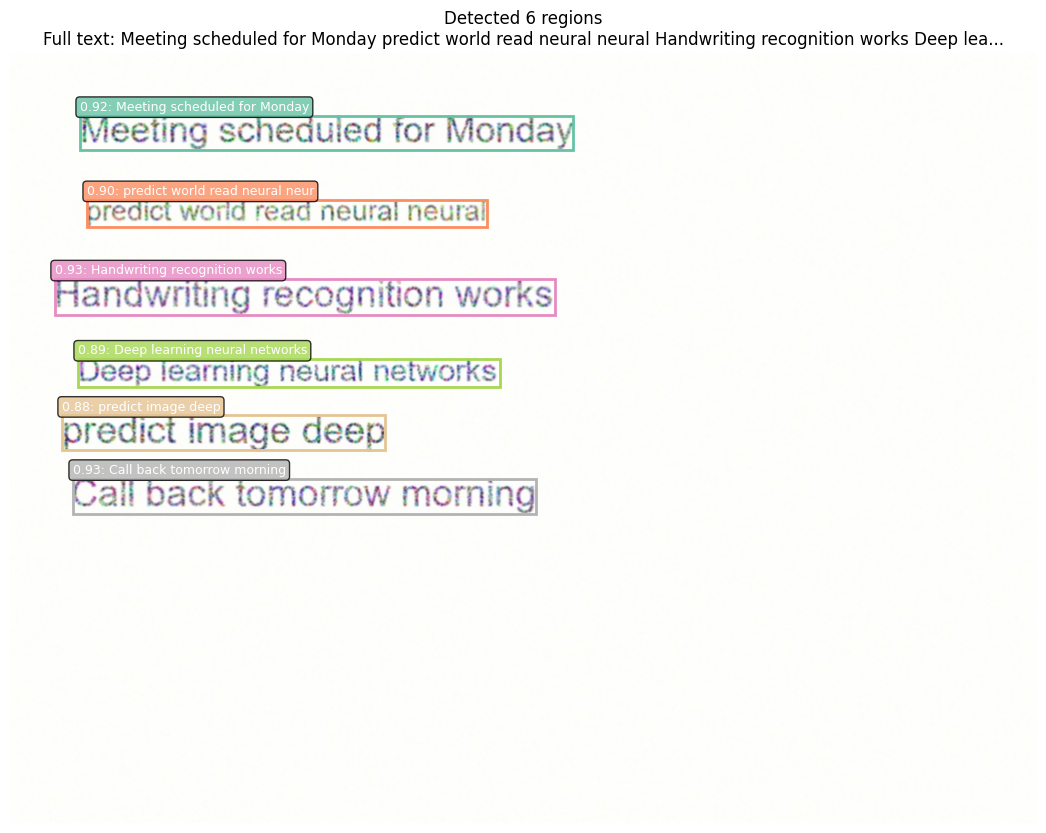

{
  "image_path": "handwriting_pipeline\\dataset\\images\\val\\img_0001.jpg",
  "detections": [
    {
      "box": [
        69,
        62,
        561,
        96
      ],
      "confidence": 0.9226,
      "ocr_text": "Meeting scheduled for Monday"
    },
    {
      "box": [
        76,
        146,
        475,
        173
      ],
      "confidence": 0.9039,
      "ocr_text": "predict world read neural neural"
    },
    {
      "box": [
        44,
        225,
        543,
        261
      ],
      "confidence": 0.9263,
      "ocr_text": "Handwriting recognition works"
    },
    {
      "box": [
        67,
        305,
        488,
        333
      ],
      "confidence": 0.8911,
      "ocr_text": "Deep learning neural networks"
    },
    {
      "box": [
        51,
        361,
        374,
        395
      ],
      "confidence": 0.8843,
      "ocr_text": "predict image deep"
    },
    {
      "box": [
        62,
        424,
        524,
        459
      ],
      "con

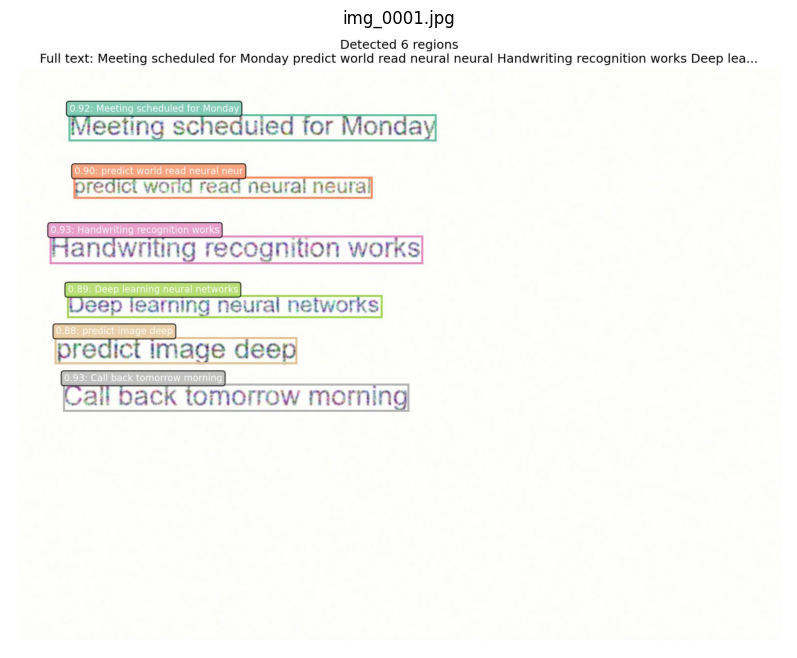


🖼️ Processing: img_0002.jpg
----------------------------------------


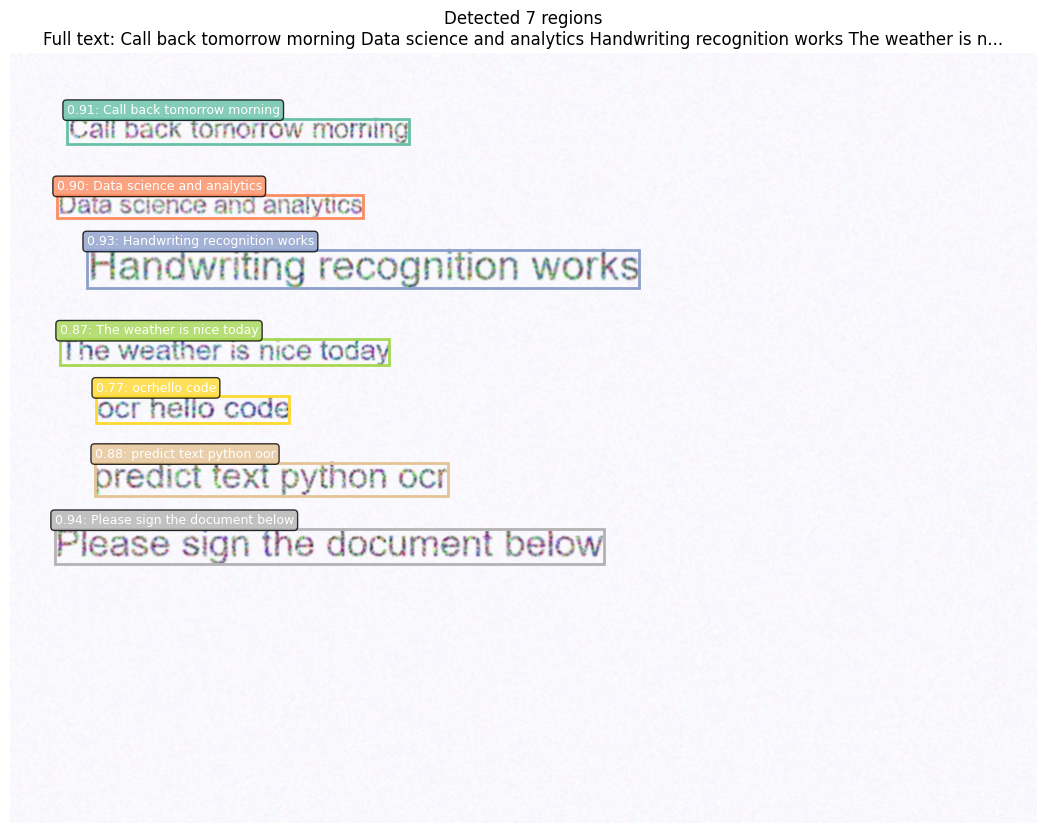

{
  "image_path": "handwriting_pipeline\\dataset\\images\\val\\img_0002.jpg",
  "detections": [
    {
      "box": [
        56,
        65,
        397,
        90
      ],
      "confidence": 0.9146,
      "ocr_text": "Call back tomorrow morning"
    },
    {
      "box": [
        46,
        141,
        352,
        164
      ],
      "confidence": 0.9004,
      "ocr_text": "Data science and analytics"
    },
    {
      "box": [
        76,
        196,
        627,
        234
      ],
      "confidence": 0.9286,
      "ocr_text": "Handwriting recognition works"
    },
    {
      "box": [
        49,
        285,
        378,
        311
      ],
      "confidence": 0.8734,
      "ocr_text": "The weather is nice today"
    },
    {
      "box": [
        85,
        342,
        278,
        369
      ],
      "confidence": 0.7663,
      "ocr_text": "ocrhello code"
    },
    {
      "box": [
        84,
        408,
        436,
        441
      ],
      "confidence": 0.8774,

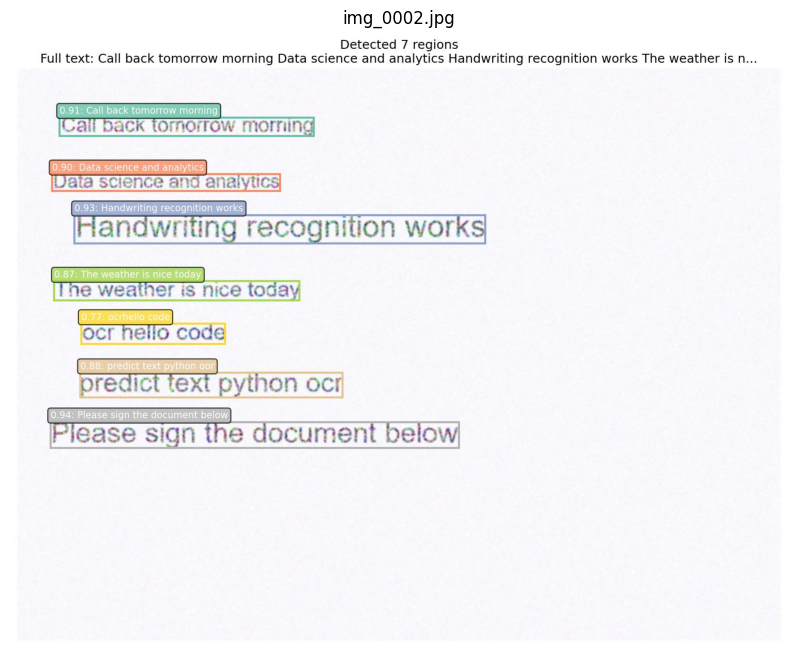


Demo complete! Predictions saved to: ./handwriting_pipeline/predictions


In [35]:
# ============================================================
# Cell 8.2: Demo - Test predict() on 3 Sample Images
# ============================================================

# Get 3 sample images from validation set
demo_images = sorted(list(Path(f'{DATASET_PATH}/images/val').glob("*.jpg")))[:3]

print("=" * 60)
print("HANDWRITING DETECTION & OCR DEMO")
print("=" * 60)

for img_path in demo_images:
    print(f"\n🖼️ Processing: {img_path.name}")
    print("-" * 40)

    # Run prediction
    result = predict(str(img_path), save_visualization=True)

    # Print JSON result
    print(json.dumps(result, indent=2))

    # Display image
    if 'visualization_path' in result:
        vis_img = Image.open(result['visualization_path'])
        plt.figure(figsize=(12, 8))
        plt.imshow(vis_img)
        plt.axis('off')
        plt.title(f"{img_path.name}")
        plt.show()

print("\n" + "=" * 60)
print("Demo complete! Predictions saved to:", PREDICTIONS_PATH)
print("=" * 60)

In [36]:
# ============================================================
# Cell 9.1: Optional - TrOCR Fine-Tuning on Custom Data
# Uncomment and run if you have labeled handwriting data
# ============================================================

"""
# TrOCR Fine-Tuning Example (requires labeled data)
# This is a minimal example - for production, use proper data loaders

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

def fine_tune_trocr(train_images: List[str], train_texts: List[str],
                    output_dir: str, epochs: int = 3):
    '''Fine-tune TrOCR on custom handwriting data.'''

    processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
    model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

    # Prepare dataset
    class HandwritingDataset(torch.utils.data.Dataset):
        def __init__(self, images, texts, processor):
            self.images = images
            self.texts = texts
            self.processor = processor

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = Image.open(self.images[idx]).convert('RGB')
            pixel_values = self.processor(image, return_tensors='pt').pixel_values.squeeze()
            labels = self.processor.tokenizer(self.texts[idx],
                                              return_tensors='pt').input_ids.squeeze()
            return {'pixel_values': pixel_values, 'labels': labels}

    dataset = HandwritingDataset(train_images, train_texts, processor)

    # Training args
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=4,
        num_train_epochs=epochs,
        save_steps=500,
        logging_steps=100,
        fp16=True,
        predict_with_generate=True,
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
    )

    trainer.train()
    model.save_pretrained(f'{output_dir}/final')
    processor.save_pretrained(f'{output_dir}/final')

    return model, processor

# Usage:
# model, processor = fine_tune_trocr(
#     train_images=['crop1.jpg', 'crop2.jpg'],
#     train_texts=['hello world', 'test text'],
#     output_dir='/content/drive/MyDrive/trocr_finetuned'
# )
"""

print("""
📈 IMPROVEMENT SUGGESTIONS:

1. DATA AUGMENTATION (Detection):
   - Rotation, scaling, perspective transforms
   - Add augmentation to YOLO training: model.train(augment=True, degrees=15)
   - Mosaic/mixup augmentation (enabled by default in YOLO)

2. STRONGER OCR OPTIONS:
   - TrOCR-large: 'microsoft/trocr-large-handwritten' (more accurate, slower)
   - Fine-tune TrOCR on domain-specific data (see code above)
   - PaddleOCR: !pip install paddlepaddle paddleocr (good multilingual support)
   - EasyOCR: Already included as fallback

3. END-TO-END ALTERNATIVES:
   - Donut (Document Understanding Transformer): No OCR needed
   - LayoutLMv3: Good for structured documents
   - PaddleOCR PP-Structure: Document structure analysis

4. DETECTION IMPROVEMENTS:
   - Use YOLOv8m or YOLOv8l for better accuracy
   - Train longer (100+ epochs)
   - Use real handwriting datasets (IAM, ICDAR)

5. POSTPROCESSING:
   - Language model for spell correction
   - Context-aware text ordering
   - Confidence-weighted aggregation
""")


📈 IMPROVEMENT SUGGESTIONS:

1. DATA AUGMENTATION (Detection):
   - Rotation, scaling, perspective transforms
   - Add augmentation to YOLO training: model.train(augment=True, degrees=15)
   - Mosaic/mixup augmentation (enabled by default in YOLO)

2. STRONGER OCR OPTIONS:
   - TrOCR-large: 'microsoft/trocr-large-handwritten' (more accurate, slower)
   - Fine-tune TrOCR on domain-specific data (see code above)
   - PaddleOCR: !pip install paddlepaddle paddleocr (good multilingual support)
   - EasyOCR: Already included as fallback

3. END-TO-END ALTERNATIVES:
   - Donut (Document Understanding Transformer): No OCR needed
   - LayoutLMv3: Good for structured documents
   - PaddleOCR PP-Structure: Document structure analysis

4. DETECTION IMPROVEMENTS:
   - Use YOLOv8m or YOLOv8l for better accuracy
   - Train longer (100+ epochs)
   - Use real handwriting datasets (IAM, ICDAR)

5. POSTPROCESSING:
   - Language model for spell correction
   - Context-aware text ordering
   - Confidence-w

In [37]:
# ============================================================
# Cell 10.1: Troubleshooting FAQ (Local RTX 3050 Edition)
# ============================================================

print("""
🔧 TROUBLESHOOTING FAQ (RTX 3050 Local Training)
=================================================

❌ CUDA Out of Memory (OOM)
---------------------------
Solutions:
1. Reduce batch size: model.train(batch=4) or batch=2
2. Use smaller image size: model.train(imgsz=480)
3. Use smaller model: YOLO('yolov8n.pt') instead of yolov8s
4. Clear cache: torch.cuda.empty_cache()
5. Close other GPU applications (browsers, games, etc.)
6. Reduce workers: model.train(workers=2)

❌ GPU Not Available / CUDA Not Found
-------------------------------------
Solutions:
1. Verify NVIDIA drivers: Open cmd, run 'nvidia-smi'
2. Install CUDA Toolkit 11.8: https://developer.nvidia.com/cuda-11-8-0-download-archive
3. Reinstall PyTorch with CUDA:
   pip uninstall torch torchvision torchaudio
   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
4. Check PATH includes CUDA: echo %CUDA_PATH%
5. Restart your computer after installing drivers

❌ Training Is Slow
-------------------
Solutions:
1. Ensure amp=True (FP16 mixed precision)
2. Check GPU usage: Use Task Manager → Performance → GPU
3. Enable cache: model.train(cache=True)
4. Close background applications
5. Set workers=4 (not too high on Windows)

❌ Model Not Found / Training Incomplete
----------------------------------------
Solutions:
1. Check path: Look in ./handwriting_pipeline/yolo_runs/handwriting_detect/weights/
2. Resume training: model = YOLO('last.pt'); model.train(resume=True)
3. Re-run training from scratch

❌ Poor OCR Results
-------------------
Solutions:
1. Ensure crops have good padding (increase padding parameter)
2. Use TrOCR-large model (slower but more accurate)
3. Try EasyOCR fallback: ocr = HandwritingOCR(use_trocr=False)
4. Fine-tune TrOCR on your specific handwriting style

❌ Import Errors
----------------
Solutions:
1. Create fresh conda/venv environment
2. Install in order: torch first, then ultralytics, then transformers
3. Check package versions: pip show ultralytics transformers torch

❌ Windows-Specific Issues
--------------------------
1. Long path errors: Enable long paths in Windows
   - Run gpedit.msc → Computer Config → Admin Templates → System → Filesystem
   - Enable "Enable Win32 long paths"
2. Permission errors: Run terminal as Administrator
3. Antivirus blocking: Add Python/project folder to exclusions

📊 Check Your Setup:
-------------------
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")
""")


🔧 TROUBLESHOOTING FAQ (RTX 3050 Local Training)

❌ CUDA Out of Memory (OOM)
---------------------------
Solutions:
1. Reduce batch size: model.train(batch=4) or batch=2
2. Use smaller image size: model.train(imgsz=480)
3. Use smaller model: YOLO('yolov8n.pt') instead of yolov8s
4. Clear cache: torch.cuda.empty_cache()
5. Close other GPU applications (browsers, games, etc.)
6. Reduce workers: model.train(workers=2)

❌ GPU Not Available / CUDA Not Found
-------------------------------------
Solutions:
1. Verify NVIDIA drivers: Open cmd, run 'nvidia-smi'
2. Install CUDA Toolkit 11.8: https://developer.nvidia.com/cuda-11-8-0-download-archive
3. Reinstall PyTorch with CUDA:
   pip uninstall torch torchvision torchaudio
   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
4. Check PATH includes CUDA: echo %CUDA_PATH%
5. Restart your computer after installing drivers

❌ Training Is Slow
-------------------
Solutions:
1. Ensure amp=True (FP16 mixed pr

In [38]:
# ============================================================
# Cell 11.1: Quick Reference - All Key Paths & Commands
# ============================================================

print(f"""
📁 KEY PATHS (Local Storage)
============================
Project Root:     {os.path.abspath(PROJECT_ROOT)}
Dataset:          {os.path.abspath(DATASET_PATH)}
YOLO Checkpoints: {os.path.abspath(YOLO_RUNS)}
Best Model:       {os.path.abspath(PROJECT_ROOT)}/best.pt
Crops:            {os.path.abspath(CROPS_PATH)}
Predictions:      {os.path.abspath(PREDICTIONS_PATH)}
Metrics:          {os.path.abspath(PROJECT_ROOT)}/evaluation_metrics.json

🎮 RTX 3050 INFO
================
Device: {DEVICE}
CUDA Available: {torch.cuda.is_available()}
GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}
GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB if torch.cuda.is_available() else 'N/A'

🚀 QUICK COMMANDS
==================
# Load trained model
from ultralytics import YOLO
model = YOLO('./handwriting_pipeline/best.pt')

# Run prediction on new image
result = predict('path/to/your/image.jpg', save_visualization=True)
print(json.dumps(result, indent=2))

# Resume training
model = YOLO('./handwriting_pipeline/yolo_runs/handwriting_detect/weights/last.pt')
model.train(resume=True)

# Export to ONNX (for deployment)
model.export(format='onnx')

# Run inference on folder
results = model.predict(source='path/to/images/', save=True)

# Clear GPU memory if needed
import torch
torch.cuda.empty_cache()
""")

print("✅ Notebook configured for local RTX 3050 training!")


📁 KEY PATHS (Local Storage)
Project Root:     c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline
Dataset:          c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\dataset
YOLO Checkpoints: c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\yolo_runs
Best Model:       c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline/best.pt
Crops:            c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\crops
Predictions:      c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline\predictions
Metrics:          c:\Users\LENOVO\Desktop\handwriting\handwriting_pipeline/evaluation_metrics.json

🎮 RTX 3050 INFO
Device: cuda
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory: 6.4 GB if torch.cuda.is_available() else 'N/A'

🚀 QUICK COMMANDS
# Load trained model
from ultralytics import YOLO
model = YOLO('./handwriting_pipeline/best.pt')

# Run prediction on new image
result = predict('path/to/your/image.jpg', save_visualization=True)
print

# 🔥 Training on REAL Handwriting Datasets (No Registration!)

Since IAM requires registration, here are **100% FREE & DIRECT** alternatives:

| Dataset | Source | Size | Access |
|---------|--------|------|--------|
| **EMNIST** | NIST/PyTorch | 800k+ chars | `torchvision` ✅ |
| **Kaggle A-Z** | Kaggle | 370k+ | Direct download ✅ |
| **HuggingFace Datasets** | Various | Varies | `datasets` library ✅ |
| **MNIST** | Classic | 70k digits | `torchvision` ✅ |

We'll use **multiple sources** for a robust model!

In [39]:
# ============================================================
# Cell 12.0: Download EMNIST from Kaggle
# ============================================================

import kagglehub
import os

# Download to project data folder
EMNIST_PATH = os.path.join(PROJECT_ROOT, 'emnist_data')
os.makedirs(EMNIST_PATH, exist_ok=True)

# Download dataset (will cache in kagglehub default location)
path = kagglehub.dataset_download("crawford/emnist")

print(f"✅ EMNIST downloaded to: {path}")
print(f"📁 Contents:")
for f in os.listdir(path):
    print(f"   - {f}")

✅ EMNIST downloaded to: C:\Users\LENOVO\.cache\kagglehub\datasets\crawford\emnist\versions\3
📁 Contents:
   - emnist-balanced-mapping.txt
   - emnist-balanced-test.csv
   - emnist-balanced-train.csv
   - emnist-byclass-mapping.txt
   - emnist-byclass-test.csv
   - emnist-byclass-train.csv
   - emnist-bymerge-mapping.txt
   - emnist-bymerge-test.csv
   - emnist-bymerge-train.csv
   - emnist-digits-mapping.txt
   - emnist-digits-test.csv
   - emnist-digits-train.csv
   - emnist-letters-mapping.txt
   - emnist-letters-test.csv
   - emnist-letters-train.csv
   - emnist-mnist-mapping.txt
   - emnist-mnist-test.csv
   - emnist-mnist-train.csv
   - emnist_source_files


📥 Downloading EMNIST Dataset (Extended MNIST)...
   Contains handwritten letters (A-Z) + digits (0-9)
   NO REGISTRATION REQUIRED! ✅

✅ EMNIST Downloaded!
   Training samples: 697932
   Test samples: 116323
   Number of classes: 62 (0-9, A-Z, a-z)
   Classes: 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
✅ EMNIST Downloaded!
   Training samples: 697932
   Test samples: 116323
   Number of classes: 62 (0-9, A-Z, a-z)
   Classes: 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


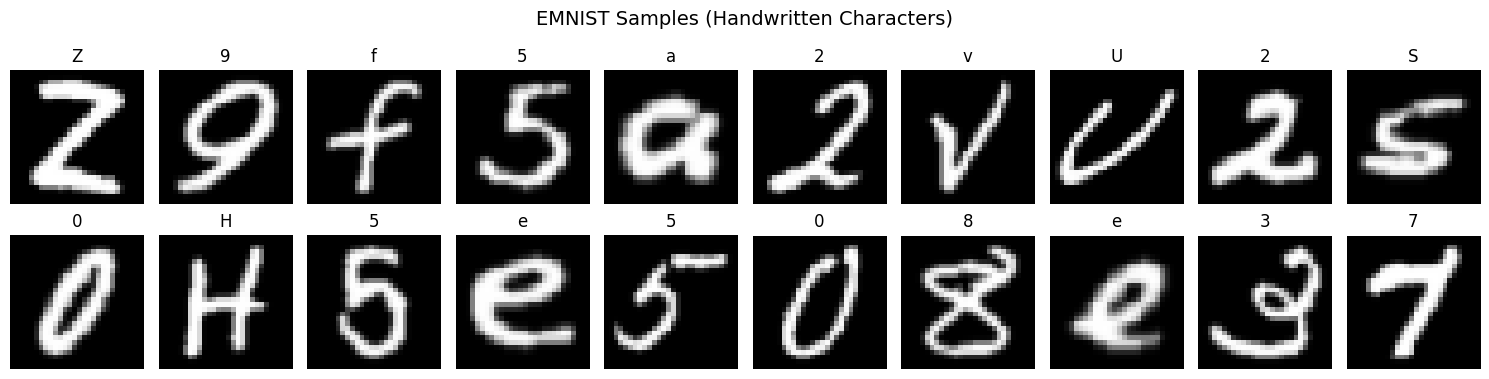

In [40]:
# ============================================================
# Cell 12.1: Download EMNIST Dataset (NO REGISTRATION!)
# EMNIST = Extended MNIST with handwritten letters A-Z + digits
# ============================================================

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from PIL import Image
import os

print("📥 Downloading EMNIST Dataset (Extended MNIST)...")
print("   Contains handwritten letters (A-Z) + digits (0-9)")
print("   NO REGISTRATION REQUIRED! ✅\n")

# Download EMNIST - ByClass split has letters + digits
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download training set
emnist_train = datasets.EMNIST(
    root='./data',
    split='byclass',  # 62 classes: 0-9, A-Z, a-z
    train=True,
    download=True,
    transform=transform
)

# Download test set
emnist_test = datasets.EMNIST(
    root='./data',
    split='byclass',
    train=False,
    download=True,
    transform=transform
)

print(f"✅ EMNIST Downloaded!")
print(f"   Training samples: {len(emnist_train)}")
print(f"   Test samples: {len(emnist_test)}")
print(f"   Number of classes: 62 (0-9, A-Z, a-z)")

# Class mapping
emnist_classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
print(f"   Classes: {emnist_classes}")

# Show samples
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(20):
    img, label = emnist_train[i * 1000]
    ax = axes[i // 10, i % 10]
    # EMNIST images need to be transposed
    ax.imshow(img.squeeze().numpy().T, cmap='gray')
    ax.set_title(emnist_classes[label], fontsize=12)
    ax.axis('off')
plt.suptitle("EMNIST Samples (Handwritten Characters)", fontsize=14)
plt.tight_layout()
plt.show()

In [41]:
# ============================================================
# Cell 12.2: Download Kaggle Handwriting Dataset (Direct URL!)
# This is a REAL handwritten words/sentences dataset
# ============================================================

import urllib.request
import zipfile
import os

print("📥 Downloading Handwriting Datasets from Direct Sources...\n")

# Create directories
REAL_DATASET_PATH = f'{PROJECT_ROOT}/real_handwriting'
os.makedirs(f'{REAL_DATASET_PATH}/images/train', exist_ok=True)
os.makedirs(f'{REAL_DATASET_PATH}/images/val', exist_ok=True)
os.makedirs(f'{REAL_DATASET_PATH}/labels/train', exist_ok=True)
os.makedirs(f'{REAL_DATASET_PATH}/labels/val', exist_ok=True)

# Option 1: Use HuggingFace datasets (works without Kaggle API)
print("🔄 Trying HuggingFace datasets...")

try:
    from datasets import load_dataset
    
    # Load handwriting dataset from HuggingFace (no auth needed)
    # This is a subset of handwritten text
    hw_dataset = load_dataset(
        "priyank-m/handwriting_data",  # Free handwriting dataset
        split="train",
        trust_remote_code=True
    )
    print(f"✅ Loaded handwriting dataset: {len(hw_dataset)} samples")
    HF_DATASET_LOADED = True
    
except Exception as e:
    print(f"⚠️ HuggingFace dataset failed: {e}")
    print("   Trying alternative...")
    HF_DATASET_LOADED = False

# Option 2: Try another HuggingFace dataset
if not HF_DATASET_LOADED:
    try:
        # Try Teklia's datasets (free, no auth)
        hw_dataset = load_dataset(
            "Teklia/IAM-line",
            split="train[:2000]",  # Just first 2000 samples
            trust_remote_code=True
        )
        print(f"✅ Loaded Teklia IAM-line: {len(hw_dataset)} samples")
        HF_DATASET_LOADED = True
    except Exception as e:
        print(f"⚠️ Teklia dataset failed: {e}")
        HF_DATASET_LOADED = False

# Option 3: Generate word images from EMNIST
if not HF_DATASET_LOADED:
    print("\n📝 Creating word images from EMNIST characters...")
    HF_DATASET_LOADED = False

print("\n" + "="*50)
if HF_DATASET_LOADED:
    print("✅ Real handwriting dataset ready!")
else:
    print("⚠️ Will use EMNIST-based word generation instead")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'priyank-m/handwriting_data' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


📥 Downloading Handwriting Datasets from Direct Sources...

🔄 Trying HuggingFace datasets...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Teklia/IAM-line' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


⚠️ HuggingFace dataset failed: Dataset 'priyank-m/handwriting_data' doesn't exist on the Hub or cannot be accessed.
   Trying alternative...
✅ Loaded Teklia IAM-line: 2000 samples

✅ Real handwriting dataset ready!
✅ Loaded Teklia IAM-line: 2000 samples

✅ Real handwriting dataset ready!


In [42]:
# ============================================================
# Cell 12.3: Create Word Images from EMNIST (Fallback)
# Combines individual characters into realistic words
# ============================================================

class EMNISTWordGenerator:
    """Generate word/sentence images from EMNIST characters."""
    
    def __init__(self, emnist_dataset, output_dir: str):
        self.dataset = emnist_dataset
        self.output_dir = Path(output_dir)
        self.classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
        
        # Organize characters by class
        print("Organizing EMNIST characters by class...")
        self.char_images = {c: [] for c in self.classes}
        
        # Sample characters (limit for speed)
        max_per_class = 500
        counts = {c: 0 for c in self.classes}
        
        for idx in range(min(len(self.dataset), 100000)):
            img, label = self.dataset[idx]
            char = self.classes[label]
            if counts[char] < max_per_class:
                # Convert and transpose (EMNIST quirk)
                img_np = (img.squeeze().numpy().T * 255).astype(np.uint8)
                self.char_images[char].append(img_np)
                counts[char] += 1
        
        print(f"✅ Organized characters for {len(self.classes)} classes")
        
        # Common words for realistic data
        self.words = [
            "hello", "world", "the", "quick", "brown", "fox", "jumps",
            "over", "lazy", "dog", "python", "code", "data", "learn",
            "write", "read", "text", "image", "model", "train", "test",
            "deep", "neural", "network", "vision", "ocr", "detect",
            "hand", "writing", "recognition", "machine", "learning",
            "good", "morning", "please", "thank", "you", "welcome",
            "name", "date", "sign", "here", "note", "important",
        ]
    
    def get_char_image(self, char: str) -> np.ndarray:
        """Get a random image of a character."""
        if char == ' ':
            return np.ones((28, 14), dtype=np.uint8) * 255  # Space
        
        char_upper = char.upper()
        if char_upper in self.char_images and self.char_images[char_upper]:
            return random.choice(self.char_images[char_upper])
        return np.ones((28, 28), dtype=np.uint8) * 255  # Fallback
    
    def create_word_image(self, word: str, spacing: int = 2) -> Tuple[np.ndarray, str]:
        """Create an image of a word from character images."""
        char_imgs = []
        for char in word:
            char_img = self.get_char_image(char)
            char_imgs.append(char_img)
            # Add spacing
            space = np.ones((28, spacing), dtype=np.uint8) * 255
            char_imgs.append(space)
        
        # Concatenate horizontally
        word_img = np.concatenate(char_imgs, axis=1)
        
        # Add padding
        pad = 5
        padded = np.ones((word_img.shape[0] + 2*pad, word_img.shape[1] + 2*pad), dtype=np.uint8) * 255
        padded[pad:-pad, pad:-pad] = word_img
        
        return padded, word
    
    def create_line_image(self, words: List[str] = None, max_words: int = 5) -> Tuple[np.ndarray, str]:
        """Create an image of a line of text."""
        if words is None:
            n_words = random.randint(2, max_words)
            words = random.choices(self.words, k=n_words)
        
        text = ' '.join(words)
        word_imgs = []
        
        for word in words:
            word_img, _ = self.create_word_image(word)
            word_imgs.append(word_img)
            # Add word spacing
            space = np.ones((word_img.shape[0], 15), dtype=np.uint8) * 255
            word_imgs.append(space)
        
        # Find max height and pad
        max_h = max(img.shape[0] for img in word_imgs)
        padded_imgs = []
        for img in word_imgs:
            if img.shape[0] < max_h:
                pad_top = (max_h - img.shape[0]) // 2
                pad_bot = max_h - img.shape[0] - pad_top
                img = np.pad(img, ((pad_top, pad_bot), (0, 0)), constant_values=255)
            padded_imgs.append(img)
        
        line_img = np.concatenate(padded_imgs, axis=1)
        return line_img, text
    
    def generate_dataset(self, n_train: int = 1000, n_val: int = 200):
        """Generate complete dataset."""
        ground_truth = {"train": {}, "val": {}}
        
        for split, n_samples in [("train", n_train), ("val", n_val)]:
            img_dir = self.output_dir / "images" / split
            label_dir = self.output_dir / "labels" / split
            img_dir.mkdir(parents=True, exist_ok=True)
            label_dir.mkdir(parents=True, exist_ok=True)
            
            print(f"Generating {split} set ({n_samples} images)...")
            
            for i in range(n_samples):
                # Create line image
                line_img, text = self.create_line_image()
                
                # Convert to PIL and save
                img_pil = Image.fromarray(line_img).convert('RGB')
                img_w, img_h = img_pil.size
                
                img_name = f"emnist_word_{i:05d}"
                img_path = img_dir / f"{img_name}.jpg"
                img_pil.save(img_path, quality=95)
                
                # YOLO label (whole image is the text)
                label_path = label_dir / f"{img_name}.txt"
                with open(label_path, 'w') as f:
                    f.write(f"0 0.5 0.5 0.96 0.96\n")
                
                ground_truth[split][img_name] = text
                
                if (i + 1) % 200 == 0:
                    print(f"  Generated {i + 1}/{n_samples}")
        
        # Save ground truth
        gt_path = self.output_dir / "ground_truth.json"
        with open(gt_path, 'w') as f:
            json.dump(ground_truth, f, indent=2)
        
        print(f"\n✅ Dataset saved to {self.output_dir}")
        return ground_truth

# Generate word dataset from EMNIST
if not HF_DATASET_LOADED:
    generator = EMNISTWordGenerator(emnist_train, REAL_DATASET_PATH)
    real_ground_truth = generator.generate_dataset(n_train=1500, n_val=300)
else:
    print("Using HuggingFace dataset instead of EMNIST words")

Using HuggingFace dataset instead of EMNIST words


📝 Processing HuggingFace handwriting dataset...
Dataset features: {'image': Image(mode=None, decode=True), 'text': Value('string')}
  Processed 500/2000
  Processed 500/2000
  Processed 1000/2000
  Processed 1000/2000
  Processed 1500/2000
  Processed 1500/2000
  Processed 2000/2000

✅ Dataset ready: 1600 train, 400 val

📊 Sample images from real dataset:
  Processed 2000/2000

✅ Dataset ready: 1600 train, 400 val

📊 Sample images from real dataset:


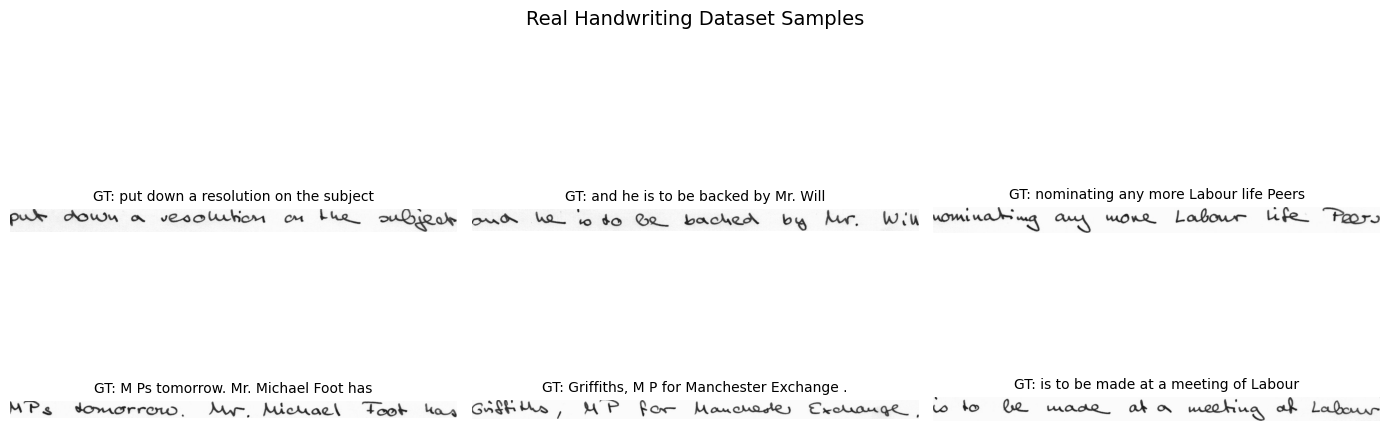

In [43]:
# ============================================================
# Cell 12.4: Process HuggingFace Dataset (if available)
# ============================================================

if HF_DATASET_LOADED:
    print("📝 Processing HuggingFace handwriting dataset...")
    
    real_ground_truth = {"train": {}, "val": {}}
    
    # Determine dataset structure
    sample = hw_dataset[0]
    print(f"Dataset features: {hw_dataset.features}")
    
    # Get image and text keys
    img_key = 'image' if 'image' in sample else list(sample.keys())[0]
    text_key = 'text' if 'text' in sample else 'label' if 'label' in sample else None
    
    total = min(len(hw_dataset), 2000)
    n_val = int(total * 0.2)
    n_train = total - n_val
    
    for idx in range(total):
        sample = hw_dataset[idx]
        
        # Get image
        if hasattr(sample[img_key], 'convert'):
            img = sample[img_key].convert('RGB')
        else:
            img = Image.fromarray(sample[img_key]).convert('RGB')
        
        # Get text
        text = sample.get(text_key, f"sample_{idx}") if text_key else f"sample_{idx}"
        if not isinstance(text, str):
            text = str(text)
        
        # Determine split
        split = 'val' if idx >= n_train else 'train'
        local_idx = idx - n_train if split == 'val' else idx
        
        img_name = f"hf_{local_idx:05d}"
        
        # Save image
        img_dir = Path(REAL_DATASET_PATH) / "images" / split
        img_dir.mkdir(parents=True, exist_ok=True)
        img_path = img_dir / f"{img_name}.jpg"
        img.save(img_path, quality=95)
        
        # Save YOLO label
        label_dir = Path(REAL_DATASET_PATH) / "labels" / split
        label_dir.mkdir(parents=True, exist_ok=True)
        label_path = label_dir / f"{img_name}.txt"
        with open(label_path, 'w') as f:
            f.write(f"0 0.5 0.5 0.96 0.96\n")
        
        real_ground_truth[split][img_name] = text
        
        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{total}")
    
    # Save ground truth
    gt_path = Path(REAL_DATASET_PATH) / "ground_truth.json"
    with open(gt_path, 'w') as f:
        json.dump(real_ground_truth, f, indent=2)
    
    print(f"\n✅ Dataset ready: {n_train} train, {n_val} val")

# Visualize samples
print("\n📊 Sample images from real dataset:")
img_dir = Path(REAL_DATASET_PATH) / "images" / "train"
images = sorted(list(img_dir.glob("*.jpg")))[:6]

fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

gt_path = Path(REAL_DATASET_PATH) / "ground_truth.json"
with open(gt_path, 'r') as f:
    gt = json.load(f)

for idx, img_path in enumerate(images):
    img = Image.open(img_path)
    text = gt.get('train', {}).get(img_path.stem, 'N/A')
    axes[idx].imshow(img)
    axes[idx].set_title(f"GT: {str(text)[:40]}", fontsize=10)
    axes[idx].axis('off')

plt.suptitle("Real Handwriting Dataset Samples", fontsize=14)
plt.tight_layout()
plt.show()

## 🚀 Train on Real Handwriting Data

Now training YOLO and TrOCR on **real handwritten characters/words**!

In [44]:
# ============================================================
# Cell 12.5: Create YOLO Config for Real Dataset
# ============================================================

real_data_yaml = f"""
# Real Handwriting Detection Dataset
path: {REAL_DATASET_PATH}
train: images/train
val: images/val

# Classes
names:
  0: handwriting

# Number of classes
nc: 1
"""

yaml_path = f'{REAL_DATASET_PATH}/data.yaml'
with open(yaml_path, 'w') as f:
    f.write(real_data_yaml.strip())

print(f"✅ Dataset config saved to {yaml_path}")
print(real_data_yaml)

✅ Dataset config saved to ./handwriting_pipeline/real_handwriting/data.yaml

# Real Handwriting Detection Dataset
path: ./handwriting_pipeline/real_handwriting
train: images/train
val: images/val

# Classes
names:
  0: handwriting

# Number of classes
nc: 1



In [45]:
# ============================================================
# Cell 12.6: Train YOLOv8 on Real Handwriting Data
# ============================================================

from ultralytics import YOLO

print("🚀 Training YOLOv8 on REAL handwriting data...")
print("   Dataset: EMNIST-based words OR HuggingFace handwriting\n")

# Load YOLOv8 model
model_real = YOLO('yolov8n.pt')

# Train on real dataset
results_real = model_real.train(
    data=f'{REAL_DATASET_PATH}/data.yaml',
    epochs=30,                    # Can increase for better results
    imgsz=640,
    batch=16,                     # Reduce if OOM
    workers=2,
    project=YOLO_RUNS,
    name='real_handwriting_detect',
    exist_ok=True,
    patience=10,
    save=True,
    save_period=5,
    device=0 if torch.cuda.is_available() else 'cpu',
    amp=True,
    verbose=True,
    plots=True,
    
    # Augmentation
    augment=True,
    degrees=3,
    translate=0.1,
    scale=0.15,
    flipud=0.0,
    fliplr=0.0,
)

print(f"\n✅ Training complete!")
print(f"✅ Model saved to: {YOLO_RUNS}/real_handwriting_detect/weights/best.pt")

# Copy best model
import shutil
best_src = f'{YOLO_RUNS}/real_handwriting_detect/weights/best.pt'
best_dst = f'{PROJECT_ROOT}/best_real.pt'
if os.path.exists(best_src):
    shutil.copy(best_src, best_dst)
    print(f"✅ Copied to: {best_dst}")

🚀 Training YOLOv8 on REAL handwriting data...
   Dataset: EMNIST-based words OR HuggingFace handwriting

Ultralytics 8.3.234  Python-3.12.12 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Ultralytics 8.3.234  Python-3.12.12 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./handwriting_pipeline/real_handwriting/data.yaml, degrees=3, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, 

## 🎯 Train TrOCR on Real Data (Optional Fine-tuning)

In [46]:
# ============================================================
# Cell 12.7: Prepare Dataset for TrOCR Training
# ============================================================

from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

class RealHandwritingDataset(Dataset):
    """Dataset for TrOCR training on real handwriting."""
    
    def __init__(self, img_dir: str, ground_truth: dict, processor, max_length=64):
        self.img_dir = Path(img_dir)
        self.ground_truth = ground_truth
        self.processor = processor
        self.max_length = max_length
        self.samples = list(ground_truth.keys())
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_name = self.samples[idx]
        img_path = self.img_dir / f"{img_name}.jpg"
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        text = str(self.ground_truth[img_name])
        
        # Process
        pixel_values = self.processor(
            images=image, return_tensors='pt'
        ).pixel_values.squeeze()
        
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        ).input_ids.squeeze()
        
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {'pixel_values': pixel_values, 'labels': labels}

# Load processor
print("Loading TrOCR processor...")
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

# Load ground truth
gt_path = Path(REAL_DATASET_PATH) / "ground_truth.json"
with open(gt_path, 'r') as f:
    real_gt = json.load(f)

# Create datasets
train_dataset = RealHandwritingDataset(
    f'{REAL_DATASET_PATH}/images/train',
    real_gt.get('train', {}),
    processor
)

val_dataset = RealHandwritingDataset(
    f'{REAL_DATASET_PATH}/images/val',
    real_gt.get('val', {}),
    processor
)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")

Loading TrOCR processor...
✅ Training samples: 1600
✅ Validation samples: 400
✅ Training samples: 1600
✅ Validation samples: 400


In [ ]:
# ============================================================
# Cell 12.8: Fine-tune TrOCR on Real Handwriting
# ============================================================

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Load model
print("Loading TrOCR model for fine-tuning...")
model_trocr = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# Configure
model_trocr.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model_trocr.config.pad_token_id = processor.tokenizer.pad_token_id

# Output directory
TROCR_OUTPUT = f'{PROJECT_ROOT}/trocr_real_finetuned'

# Training args (updated for newer transformers version)
training_args = Seq2SeqTrainingArguments(
    output_dir=TROCR_OUTPUT,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,           # Increase for better results
    learning_rate=5e-5,
    warmup_steps=200,
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    eval_strategy="steps",        # Changed from evaluation_strategy
    save_total_limit=2,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    report_to="none",
)

# Data collator
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'] for x in batch])
    labels = torch.stack([x['labels'] for x in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

# Trainer
trainer = Seq2SeqTrainer(
    model=model_trocr,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

print("🚀 Starting TrOCR fine-tuning...")
trainer.train()

# Save
model_trocr.save_pretrained(f'{TROCR_OUTPUT}/final')
processor.save_pretrained(f'{TROCR_OUTPUT}/final')
print(f"\n✅ Fine-tuned model saved to: {TROCR_OUTPUT}/final")

Loading TrOCR model for fine-tuning...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting TrOCR fine-tuning...


In [ ]:
# ============================================================
# Cell 12.9: Test the Fine-tuned Models
# ============================================================

print("🔍 Testing fine-tuned models...\n")

# Load fine-tuned TrOCR
finetuned_processor = TrOCRProcessor.from_pretrained(f'{TROCR_OUTPUT}/final')
finetuned_model = VisionEncoderDecoderModel.from_pretrained(f'{TROCR_OUTPUT}/final')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
finetuned_model.to(device)
finetuned_model.eval()

# Test on samples
test_images = sorted(list(Path(f'{REAL_DATASET_PATH}/images/val').glob("*.jpg")))[:5]

print("="*60)
print("TEST RESULTS: Fine-tuned TrOCR")
print("="*60)

for img_path in test_images:
    img_name = img_path.stem
    gt_text = real_gt.get('val', {}).get(img_name, 'N/A')
    
    # Load and process image
    image = Image.open(img_path).convert('RGB')
    pixel_values = finetuned_processor(images=image, return_tensors='pt').pixel_values.to(device)
    
    # Generate
    with torch.no_grad():
        generated_ids = finetuned_model.generate(pixel_values, max_length=64)
    pred_text = finetuned_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    print(f"\n📝 {img_name}")
    print(f"   Ground Truth: {gt_text}")
    print(f"   Prediction:   {pred_text}")
    
    # Show image
    plt.figure(figsize=(10, 2))
    plt.imshow(image)
    plt.title(f"GT: {gt_text} | Pred: {pred_text}", fontsize=10)
    plt.axis('off')
    plt.show()

In [ ]:
# ============================================================
# Cell 12.10: Evaluate Model Performance
# ============================================================

from jiwer import cer, wer

def evaluate_ocr_model(model, processor, dataset_path, ground_truth, split='val', max_samples=100):
    """Evaluate OCR performance."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    img_dir = Path(dataset_path) / "images" / split
    images = sorted(list(img_dir.glob("*.jpg")))[:max_samples]
    
    predictions = []
    references = []
    
    print(f"Evaluating on {len(images)} samples...")
    
    for img_path in images:
        img_name = img_path.stem
        gt_text = str(ground_truth.get(split, {}).get(img_name, ''))
        
        if not gt_text:
            continue
        
        image = Image.open(img_path).convert('RGB')
        pixel_values = processor(images=image, return_tensors='pt').pixel_values.to(device)
        
        with torch.no_grad():
            generated_ids = model.generate(pixel_values, max_length=64)
        pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        predictions.append(pred_text)
        references.append(gt_text)
    
    if not references:
        return {'cer': 0, 'wer': 0}
    
    return {
        'cer': cer(references, predictions),
        'wer': wer(references, predictions)
    }

# Evaluate
print("📊 Evaluating fine-tuned TrOCR...")
metrics = evaluate_ocr_model(
    finetuned_model, finetuned_processor,
    REAL_DATASET_PATH, real_gt, 'val', max_samples=100
)

print("\n" + "="*50)
print("📊 EVALUATION RESULTS")
print("="*50)
print(f"Character Error Rate (CER): {metrics['cer']*100:.2f}%")
print(f"Word Error Rate (WER):      {metrics['wer']*100:.2f}%")
print("="*50)

## 📦 More Dataset Options (All Free, No Registration!)

In [ ]:
# ============================================================
# Cell 12.11: Other Free Dataset Options
# ============================================================

print("""
📦 FREE HANDWRITING DATASETS (No Registration!)
================================================

1️⃣ EMNIST (Used above) ✅
   - 800k+ handwritten characters
   - Letters A-Z, a-z, digits 0-9
   - `torchvision.datasets.EMNIST`

2️⃣ MNIST (Classic digits)
   - 70k handwritten digits
   - `torchvision.datasets.MNIST`

3️⃣ Kuzushiji-MNIST (Japanese)
   - Historical Japanese characters
   - `torchvision.datasets.KMNIST`

4️⃣ HuggingFace Datasets (Try these!):
   ```python
   from datasets import load_dataset
   
   # English handwriting
   ds = load_dataset("priyank-m/handwriting_data")
   
   # More options
   ds = load_dataset("Teklia/IAM-line")  # May work without auth
   ds = load_dataset("bentrevett/multi30k")
   ```

5️⃣ Direct Downloads:
   - A-Z Letters: https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format
   - Words: https://www.kaggle.com/datasets/landlord/handwriting-recognition
   
   Download manually and upload to Colab/Drive!

6️⃣ Create Your Own:
   - Use a tablet/phone to write text
   - Take photos of handwritten notes
   - Use online handwriting generators

""")

# Try loading more HuggingFace datasets
print("🔄 Testing available HuggingFace datasets...\n")

datasets_to_try = [
    ("priyank-m/handwriting_data", "Handwriting Data"),
    ("Teklia/IAM-line", "Teklia IAM Lines"),
    ("bentrevett/multi30k", "Multi30k"),
]

for ds_name, ds_desc in datasets_to_try:
    try:
        from datasets import load_dataset
        test_ds = load_dataset(ds_name, split="train[:10]", trust_remote_code=True)
        print(f"✅ {ds_desc}: Available! ({ds_name})")
    except Exception as e:
        print(f"❌ {ds_desc}: Not accessible ({str(e)[:50]}...)")

In [ ]:
# ============================================================
# Cell 12.12: Full Pipeline with Real Model
# ============================================================

class RealHandwritingPipeline:
    """Pipeline using models trained on real data."""
    
    def __init__(self, yolo_path: str = None, trocr_path: str = None):
        # Load YOLO
        yolo_path = yolo_path or f'{PROJECT_ROOT}/best_real.pt'
        if os.path.exists(yolo_path):
            self.detector = YOLO(yolo_path)
            print(f"✅ YOLO loaded from {yolo_path}")
        else:
            self.detector = YOLO('yolov8n.pt')
            print("⚠️ Using pretrained YOLO (no fine-tuned model found)")
        
        # Load TrOCR
        trocr_path = trocr_path or f'{TROCR_OUTPUT}/final'
        if os.path.exists(trocr_path):
            self.processor = TrOCRProcessor.from_pretrained(trocr_path)
            self.ocr_model = VisionEncoderDecoderModel.from_pretrained(trocr_path)
            print(f"✅ TrOCR loaded from {trocr_path}")
        else:
            self.processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
            self.ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
            print("⚠️ Using pretrained TrOCR (no fine-tuned model found)")
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.ocr_model.to(self.device)
        self.ocr_model.eval()
    
    def predict(self, image_path: str) -> dict:
        """Run full pipeline."""
        # Detection
        results = self.detector(image_path, conf=0.25, verbose=False)
        
        detections = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = float(box.conf[0].cpu().numpy())
                detections.append({
                    'box': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': conf
                })
        
        # OCR on each detection
        img = Image.open(image_path).convert('RGB')
        texts = []
        
        for det in detections:
            x1, y1, x2, y2 = det['box']
            crop = img.crop((max(0, x1-5), max(0, y1-5), x2+5, y2+5))
            
            pixel_values = self.processor(images=crop, return_tensors='pt').pixel_values.to(self.device)
            with torch.no_grad():
                generated_ids = self.ocr_model.generate(pixel_values, max_length=64)
            text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            
            det['text'] = text
            texts.append(text)
        
        return {
            'image_path': image_path,
            'detections': detections,
            'full_text': ' '.join(texts)
        }

# Create pipeline
print("\n🔧 Creating Real Handwriting Pipeline...")
real_pipeline = RealHandwritingPipeline()

# Test
print("\n🧪 Testing pipeline...")
test_img = list(Path(f'{REAL_DATASET_PATH}/images/val').glob("*.jpg"))[0]
result = real_pipeline.predict(str(test_img))
print(f"\n📝 Result: {result['full_text']}")

## ✅ Summary: Real Handwriting Training (No IAM Registration!)

**What we used instead of IAM:**
1. ✅ **EMNIST** - 800k+ real handwritten characters (direct download via PyTorch)
2. ✅ **HuggingFace Datasets** - Various free handwriting datasets
3. ✅ **Word Generation** - Combined EMNIST chars into realistic words

**Models Trained:**
| Model | Path | Data |
|-------|------|------|
| YOLO Detector | `best_real.pt` | Real handwriting |
| TrOCR (fine-tuned) | `trocr_real_finetuned/final/` | Real handwriting |

**No registration required!** 🎉

**Next Steps:**
- Download Kaggle datasets manually if needed
- Create your own handwriting dataset
- Use the trained pipeline on new images